In [1]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm
from segtok import tokenizer
from utils import *
import hickle

In [2]:
# Key Hyperparameters
enable_orig = "orig"
enable_aug = False
enable_aug3 = False
max_training_samples = 100000
max_tokenized_length = 64
num_sentences = 10
valid_percent = 0.01

batch_size_finetuning = 32
epochs_finetuning = 1
lr_finetuning = 1e-5

batch_size = 128
epochs = 20
main_model_lr = 1e-5

lstm_hidden_size = 1024
regressive_style_finetuning = False

experiment_id = f"test"

In [3]:
# Parameters
regressive_style_finetuning = True
enable_orig = False
enable_aug = False
enable_aug3 = True
max_training_samples = 200000
lstm_hidden_size = 1024
epochs = 20
experiment_id = "classification-sentence-embeddings-regressive_style_finetuning-True-enable_orig-False-enable_aug-False-enable_aug3-True-max_training_samples-200000-lstm_hidden_size-1024-epochs-20"


In [4]:
import os
experiment_dir = f"completed-experiments/{experiment_id}"
if not os.path.exists(experiment_dir):
    os.makedirs(experiment_dir)

In [5]:
from data_parsing import *
data = load_dataset("./yelp_review_training_dataset.jsonl")

In [6]:
from training_utils import split_train_validation
from text_preprocessing import preprocess
import random

def get_train_valid():
    orig_train_x, valid_x, orig_train_y, valid_y = split_train_validation(data, 0.01)
    train_x = []
    train_y = []

    if enable_aug:
        aug_data = load_gen_dataset("./new_data.json") + load_gen_dataset("./new_data2.json")
        train_x += [i[0] for i in aug_data]
        train_y += [i[1] for i in aug_data]

    if enable_aug3:
        aug_data3 = load_gen_dataset("./new_data3.json")
        train_x += [i[0] for i in aug_data3]
        train_y += [i[1] for i in aug_data3]
        
    if enable_orig:
        train_x += orig_train_x
        train_y += orig_train_y
    
    train_x = train_x[:max_training_samples]
    train_y = train_y[:max_training_samples]

    if enable_orig == "preprocess":
        train_x = preprocess(train_x)
        valid_x = preprocess(valid_x)    

    paired_train = list(zip(train_x, train_y))
    random.shuffle(paired_train)
    train_x = [i[0] for i in paired_train]
    train_y = [i[1] for i in paired_train]

    return [x.encode("utf-8") for x in train_x], [x.encode("utf-8") for x in valid_x], train_y, valid_y

split_key = f"cache-core/split-data-{valid_percent}-orig-{enable_orig}-aug12-{enable_aug}-aug3-{enable_aug3}-max-{max_training_samples}"
train_x, valid_x, train_y, valid_y = memo_load(
    get_train_valid,
    split_key
)
split_hash = hash_file(split_key + ".hkl")

train_x = [x.decode("utf-8") for x in train_x]
valid_x = [x.decode("utf-8") for x in valid_x]

In [7]:
print(len(train_x))
print(len(train_y))
print(len(valid_x))
print(len(valid_y))

5000
5000
5336
5336


In [8]:
import torch as th

device = th.device("cuda" if th.cuda.is_available() else "cpu")
print(device)

from spacy.lang.en import English
nlp = English()
nlp.add_pipe("sentencizer")

cuda


In [9]:
from transformers import BertTokenizerFast, BertForSequenceClassification
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

In [10]:
# fine tune the BERT
import numpy as np

def get_finetuning_data():
    train_x_numerized = []
    train_x_mask = []
    train_y_per_sentence = []
    for i, text in tqdm(list(enumerate(train_x))):
        doc = nlp(text)
        sents = [str(sent) for sent in doc.sents]
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            train_x_numerized.append(tokenized.ids)
            train_x_mask.append(tokenized.attention_mask)
            train_y_per_sentence.append(train_y[i])

    valid_x_numerized = []
    valid_x_mask = []
    valid_y_per_sentence = []
    for i, text in tqdm(list(enumerate(valid_x))):
        doc = nlp(text)
        sents = [str(sent) for sent in doc.sents]
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            valid_x_numerized.append(tokenized.ids)
            valid_x_mask.append(tokenized.attention_mask)
            valid_y_per_sentence.append(valid_y[i])

    train_x_numerized = np.array(train_x_numerized)
    train_x_mask = np.array(train_x_mask)
    train_y_per_sentence = np.array(train_y_per_sentence)
    valid_x_numerized = np.array(valid_x_numerized)
    valid_x_mask = np.array(valid_x_mask)
    valid_y_per_sentence = np.array(valid_y_per_sentence)
    return train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence

from utils import memo_load
finetuning_data_key = f"cache-core/training-data-finetuning-max-tokens-{max_tokenized_length}-split-{split_hash}"
(train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence) = memo_load(
    lambda: get_finetuning_data(),
    finetuning_data_key
)
finetuning_data_hash = hash_file(finetuning_data_key + ".hkl")

In [11]:
from model import ReviewPredictionModel
import torch.optim as optim

def train_finetuning():
    if regressive_style_finetuning:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1)
    else:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=9)

    model_to_train_finetuning = ReviewPredictionModel(0, max_tokenized_length, regressive_bert_style=regressive_style_finetuning)
    model_to_train_finetuning.transformer = embedding_bert
    model_to_train_finetuning.to(device)
    optimizer = optim.Adam(model_to_train_finetuning.parameters(), lr=lr_finetuning)
    
    training_accuracies_finetuning, validation_accuracies_finetuning = run_training_loop(
        model_to_train_finetuning, optimizer, device,
        batch_size_finetuning, epochs_finetuning,
        train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence,
        max_validation_examples=256,
        model_id=experiment_id, tag="finetuning"
    )
    
    return embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning

def store_finetuning(tup, folder):
    embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning = tup
    th.save(embedding_bert.state_dict(), f"{folder}/model.pt")
    hickle.dump((training_accuracies_finetuning, validation_accuracies_finetuning), f"{folder}/accuracies.hkl", mode="w")

def load_finetuning(folder):
    if regressive_style_finetuning:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1)
    else:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=9)
    embedding_bert.load_state_dict(th.load(f"{folder}/model.pt"))
    embedding_bert.eval()
    embedding_bert.to(device)
    training_accuracies_finetuning, validation_accuracies_finetuning = hickle.load(f"{folder}/accuracies.hkl")
    return embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning

In [12]:
from training_utils import run_training_loop

from utils import memo_load
finetuning_model_key = f"cache-core/finetuning-batch-size-{batch_size_finetuning}-epochs-{epochs_finetuning}-lr-{lr_finetuning}-regressive-{regressive_style_finetuning}-data-{finetuning_data_hash}"
embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning = manual_memo(
    train_finetuning, store_finetuning, load_finetuning,
    finetuning_model_key
)

th.save(embedding_bert.state_dict(), f"{experiment_dir}/finetuned-bert.pt")
hickle.dump((training_accuracies_finetuning, validation_accuracies_finetuning), f"{experiment_dir}/finetuning-accuracies.hkl", mode="w")

finetuning_model_hash = hash_file(finetuning_model_key + "/model.pt")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


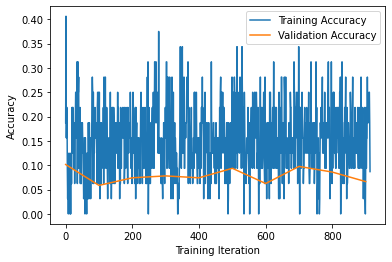

In [13]:
import matplotlib.pyplot as plt
plt.plot(range(len(training_accuracies_finetuning)), training_accuracies_finetuning, label = "Training Accuracy")
plt.plot(list(map(lambda x: x * 100, range(len(validation_accuracies_finetuning)))), validation_accuracies_finetuning, label = "Validation Accuracy")
plt.xlabel("Training Iteration")
plt.ylabel("Accuracy")
plt.legend()

In [14]:
import torch as th
import numpy as np

embedding_bert.to(device)

def get_embeds(x_data):
    concatted_shape = None
    pad_value = None
    embeds = []
    for text in tqdm(x_data):
        doc = nlp(text)
        embeddeds = []
        sents = list(doc.sents)
        all_tokenized = []
        for sentence in sents[:num_sentences]:
            sentence = str(sentence)
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            all_tokenized.append(tokenized.ids)
        
        with th.no_grad():
            sentence_tensor = th.tensor(all_tokenized).to(device)
            concatted = np.concatenate([
                # take output corresponding to CLS
                embedding_bert.bert(sentence_tensor, output_hidden_states=True, return_dict=True)[1].cpu().numpy(),
                np.zeros((len(all_tokenized), 1))
            ], axis=1)
            
            if not concatted_shape:
                concatted_shape = concatted.shape
                pad_value = np.zeros(concatted_shape[1])
                pad_value[-1] = 1
            
            embeddeds += list(concatted)

        if len(sents) < num_sentences:
            embeddeds += [pad_value] * (num_sentences - len(sents))

        embeds.append(embeddeds)
    return np.array(embeds)

main_data_key = f"cache-core/training-data-main-max-tokens-{max_tokenized_length}-split-{split_hash}-finetuned-{finetuning_model_hash}"
train_x_embeds, valid_x_embeds = memo_load(
    lambda: (
        get_embeds(train_x),
        get_embeds(valid_x)
    ),
    main_data_key
)
main_data_hash = hash_file(main_data_key + ".hkl")

In [15]:
from model_sentence_lstm import ReviewPredictionModel
import torch as th
import torch.optim as optim

def train_main():
    model_to_train = ReviewPredictionModel(train_x_embeds.shape[2], lstm_hidden_size)
    model_to_train.to(device)
    optimizer = optim.Adam(model_to_train.parameters(), lr=main_model_lr)
    
    training_accuracies, validation_accuracies = run_training_loop(
        model_to_train, optimizer, device,
        batch_size, epochs,
        train_x_embeds, None, np.array(train_y), valid_x_embeds, None, np.array(valid_y),
        model_id=experiment_id, max_validation_examples=512
    )
    
    return model_to_train, training_accuracies, validation_accuracies

def store_main(tup, folder):
    model_to_train, training_accuracies, validation_accuracies = tup
    th.save(model_to_train.state_dict(), f"{folder}/model.pt")
    hickle.dump((training_accuracies, validation_accuracies), f"{folder}/accuracies.hkl", mode="w")

def load_main(folder):
    model_to_train = ReviewPredictionModel(train_x_embeds.shape[2], lstm_hidden_size)
    model_to_train.load_state_dict(th.load(f"{folder}/model.pt"))
    model_to_train.eval()
    model_to_train.to(device)
    training_accuracies, validation_accuracies = hickle.load(f"{folder}/accuracies.hkl")
    return model_to_train, training_accuracies, validation_accuracies

In [16]:
from training_utils import run_training_loop

main_model_key = f"cache-core/main-model-lstm-{lstm_hidden_size}-lr-{main_model_lr}-batch-size-{batch_size}-epochs-{epochs}-data-{main_data_hash}"
main_model, training_accuracies, validation_accuracies = manual_memo(
    train_main, store_main, load_main,
    main_model_key
)

th.save(main_model.state_dict(), f"{experiment_dir}/main-model.pt")
hickle.dump((training_accuracies, validation_accuracies), f"{experiment_dir}/main-accuracies.hkl", mode="w")

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 0 Loss: 2.228 Validation Loss: 2.191 Accuracy: 0.055 Validation Accuracy: 0.152:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 1 Loss: 2.228 Validation Loss: 2.191 Accuracy: 0.066 Validation Accuracy: 0.152:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 2 Loss: 2.228 Validation Loss: 2.191 Accuracy: 0.078 Validation Accuracy: 0.152:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 3 Loss: 2.224 Validation Loss: 2.191 Accuracy: 0.102 Validation Accuracy: 0.152:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 4 Loss: 2.223 Validation Loss: 2.191 Accuracy: 0.113 Validation Accuracy: 0.152:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 5 Loss: 2.219 Validation Loss: 2.191 Accuracy: 0.143 Validation Accuracy: 0.152:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 6 Loss: 2.218 Validation Loss: 2.191 Accuracy: 0.146 Validation Accuracy: 0.152:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 7 Loss: 2.215 Validation Loss: 2.191 Accuracy: 0.169 Validation Accuracy: 0.152:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 8 Loss: 2.213 Validation Loss: 2.191 Accuracy: 0.171 Validation Accuracy: 0.152:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 9 Loss: 2.210 Validation Loss: 2.191 Accuracy: 0.188 Validation Accuracy: 0.152:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 10 Loss: 2.208 Validation Loss: 2.191 Accuracy: 0.202 Validation Accuracy: 0.152:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 10 Loss: 2.208 Validation Loss: 2.191 Accuracy: 0.202 Validation Accuracy: 0.152:  28%|██▊       | 11/40 [00:00<00:00, 103.22it/s]

Epoch: 0 Iteration: 11 Loss: 2.205 Validation Loss: 2.191 Accuracy: 0.223 Validation Accuracy: 0.152:  28%|██▊       | 11/40 [00:00<00:00, 103.22it/s]

Epoch: 0 Iteration: 12 Loss: 2.202 Validation Loss: 2.191 Accuracy: 0.246 Validation Accuracy: 0.152:  28%|██▊       | 11/40 [00:00<00:00, 103.22it/s]

Epoch: 0 Iteration: 13 Loss: 2.200 Validation Loss: 2.191 Accuracy: 0.259 Validation Accuracy: 0.152:  28%|██▊       | 11/40 [00:00<00:00, 103.22it/s]

Epoch: 0 Iteration: 14 Loss: 2.198 Validation Loss: 2.191 Accuracy: 0.279 Validation Accuracy: 0.152:  28%|██▊       | 11/40 [00:00<00:00, 103.22it/s]

Epoch: 0 Iteration: 15 Loss: 2.196 Validation Loss: 2.191 Accuracy: 0.280 Validation Accuracy: 0.152:  28%|██▊       | 11/40 [00:00<00:00, 103.22it/s]

Epoch: 0 Iteration: 16 Loss: 2.193 Validation Loss: 2.191 Accuracy: 0.294 Validation Accuracy: 0.152:  28%|██▊       | 11/40 [00:00<00:00, 103.22it/s]

Epoch: 0 Iteration: 17 Loss: 2.191 Validation Loss: 2.191 Accuracy: 0.287 Validation Accuracy: 0.152:  28%|██▊       | 11/40 [00:00<00:00, 103.22it/s]

Epoch: 0 Iteration: 18 Loss: 2.188 Validation Loss: 2.191 Accuracy: 0.309 Validation Accuracy: 0.152:  28%|██▊       | 11/40 [00:00<00:00, 103.22it/s]

Epoch: 0 Iteration: 19 Loss: 2.186 Validation Loss: 2.191 Accuracy: 0.302 Validation Accuracy: 0.152:  28%|██▊       | 11/40 [00:00<00:00, 103.22it/s]

Epoch: 0 Iteration: 20 Loss: 2.181 Validation Loss: 2.191 Accuracy: 0.312 Validation Accuracy: 0.152:  28%|██▊       | 11/40 [00:00<00:00, 103.22it/s]

Epoch: 0 Iteration: 21 Loss: 2.176 Validation Loss: 2.191 Accuracy: 0.312 Validation Accuracy: 0.152:  28%|██▊       | 11/40 [00:00<00:00, 103.22it/s]

Epoch: 0 Iteration: 22 Loss: 2.170 Validation Loss: 2.191 Accuracy: 0.310 Validation Accuracy: 0.152:  28%|██▊       | 11/40 [00:00<00:00, 103.22it/s]

Epoch: 0 Iteration: 23 Loss: 2.165 Validation Loss: 2.191 Accuracy: 0.316 Validation Accuracy: 0.152:  28%|██▊       | 11/40 [00:00<00:00, 103.22it/s]

Epoch: 0 Iteration: 24 Loss: 2.160 Validation Loss: 2.191 Accuracy: 0.315 Validation Accuracy: 0.152:  28%|██▊       | 11/40 [00:00<00:00, 103.22it/s]

Epoch: 0 Iteration: 24 Loss: 2.160 Validation Loss: 2.191 Accuracy: 0.315 Validation Accuracy: 0.152:  62%|██████▎   | 25/40 [00:00<00:00, 121.25it/s]

Epoch: 0 Iteration: 25 Loss: 2.155 Validation Loss: 2.191 Accuracy: 0.312 Validation Accuracy: 0.152:  62%|██████▎   | 25/40 [00:00<00:00, 121.25it/s]

Epoch: 0 Iteration: 26 Loss: 2.150 Validation Loss: 2.191 Accuracy: 0.312 Validation Accuracy: 0.152:  62%|██████▎   | 25/40 [00:00<00:00, 121.25it/s]

Epoch: 0 Iteration: 27 Loss: 2.146 Validation Loss: 2.191 Accuracy: 0.322 Validation Accuracy: 0.152:  62%|██████▎   | 25/40 [00:00<00:00, 121.25it/s]

Epoch: 0 Iteration: 28 Loss: 2.141 Validation Loss: 2.191 Accuracy: 0.323 Validation Accuracy: 0.152:  62%|██████▎   | 25/40 [00:00<00:00, 121.25it/s]

Epoch: 0 Iteration: 29 Loss: 2.137 Validation Loss: 2.191 Accuracy: 0.330 Validation Accuracy: 0.152:  62%|██████▎   | 25/40 [00:00<00:00, 121.25it/s]

Epoch: 0 Iteration: 30 Loss: 2.132 Validation Loss: 2.191 Accuracy: 0.331 Validation Accuracy: 0.152:  62%|██████▎   | 25/40 [00:00<00:00, 121.25it/s]

Epoch: 0 Iteration: 31 Loss: 2.127 Validation Loss: 2.191 Accuracy: 0.336 Validation Accuracy: 0.152:  62%|██████▎   | 25/40 [00:00<00:00, 121.25it/s]

Epoch: 0 Iteration: 32 Loss: 2.122 Validation Loss: 2.191 Accuracy: 0.336 Validation Accuracy: 0.152:  62%|██████▎   | 25/40 [00:00<00:00, 121.25it/s]

Epoch: 0 Iteration: 33 Loss: 2.116 Validation Loss: 2.191 Accuracy: 0.342 Validation Accuracy: 0.152:  62%|██████▎   | 25/40 [00:00<00:00, 121.25it/s]

Epoch: 0 Iteration: 34 Loss: 2.112 Validation Loss: 2.191 Accuracy: 0.337 Validation Accuracy: 0.152:  62%|██████▎   | 25/40 [00:00<00:00, 121.25it/s]

Epoch: 0 Iteration: 35 Loss: 2.107 Validation Loss: 2.191 Accuracy: 0.344 Validation Accuracy: 0.152:  62%|██████▎   | 25/40 [00:00<00:00, 121.25it/s]

Epoch: 0 Iteration: 36 Loss: 2.101 Validation Loss: 2.191 Accuracy: 0.346 Validation Accuracy: 0.152:  62%|██████▎   | 25/40 [00:00<00:00, 121.25it/s]

Epoch: 0 Iteration: 37 Loss: 2.096 Validation Loss: 2.191 Accuracy: 0.348 Validation Accuracy: 0.152:  62%|██████▎   | 25/40 [00:00<00:00, 121.25it/s]

Epoch: 0 Iteration: 38 Loss: 2.092 Validation Loss: 2.191 Accuracy: 0.348 Validation Accuracy: 0.152:  62%|██████▎   | 25/40 [00:00<00:00, 121.25it/s]

Epoch: 0 Iteration: 39 Loss: 2.087 Validation Loss: 2.191 Accuracy: 0.327 Validation Accuracy: 0.152:  62%|██████▎   | 25/40 [00:00<00:00, 121.25it/s]

Epoch: 0 Iteration: 39 Loss: 2.087 Validation Loss: 2.191 Accuracy: 0.327 Validation Accuracy: 0.152: 100%|██████████| 40/40 [00:00<00:00, 131.25it/s]

Epoch: 0 Iteration: 39 Loss: 2.087 Validation Loss: 2.191 Accuracy: 0.327 Validation Accuracy: 0.152: 100%|██████████| 40/40 [00:00<00:00, 126.53it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 0 Loss: 2.082 Validation Loss: 2.219 Accuracy: 0.331 Validation Accuracy: 0.132:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 1 Loss: 2.076 Validation Loss: 2.219 Accuracy: 0.348 Validation Accuracy: 0.132:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 2 Loss: 2.073 Validation Loss: 2.219 Accuracy: 0.359 Validation Accuracy: 0.132:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 3 Loss: 2.067 Validation Loss: 2.219 Accuracy: 0.352 Validation Accuracy: 0.132:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 4 Loss: 2.064 Validation Loss: 2.219 Accuracy: 0.362 Validation Accuracy: 0.132:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 5 Loss: 2.055 Validation Loss: 2.219 Accuracy: 0.375 Validation Accuracy: 0.132:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 6 Loss: 2.048 Validation Loss: 2.219 Accuracy: 0.387 Validation Accuracy: 0.132:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 7 Loss: 2.040 Validation Loss: 2.219 Accuracy: 0.389 Validation Accuracy: 0.132:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 8 Loss: 2.033 Validation Loss: 2.219 Accuracy: 0.388 Validation Accuracy: 0.132:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 9 Loss: 2.025 Validation Loss: 2.219 Accuracy: 0.411 Validation Accuracy: 0.132:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 10 Loss: 2.020 Validation Loss: 2.219 Accuracy: 0.421 Validation Accuracy: 0.132:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 11 Loss: 2.014 Validation Loss: 2.219 Accuracy: 0.416 Validation Accuracy: 0.132:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 12 Loss: 2.009 Validation Loss: 2.219 Accuracy: 0.415 Validation Accuracy: 0.132:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 12 Loss: 2.009 Validation Loss: 2.219 Accuracy: 0.415 Validation Accuracy: 0.132:  32%|███▎      | 13/40 [00:00<00:00, 121.91it/s]

Epoch: 1 Iteration: 13 Loss: 2.004 Validation Loss: 2.219 Accuracy: 0.420 Validation Accuracy: 0.132:  32%|███▎      | 13/40 [00:00<00:00, 121.91it/s]

Epoch: 1 Iteration: 14 Loss: 1.998 Validation Loss: 2.219 Accuracy: 0.425 Validation Accuracy: 0.132:  32%|███▎      | 13/40 [00:00<00:00, 121.91it/s]

Epoch: 1 Iteration: 15 Loss: 1.989 Validation Loss: 2.219 Accuracy: 0.427 Validation Accuracy: 0.132:  32%|███▎      | 13/40 [00:00<00:00, 121.91it/s]

Epoch: 1 Iteration: 16 Loss: 1.983 Validation Loss: 2.219 Accuracy: 0.420 Validation Accuracy: 0.132:  32%|███▎      | 13/40 [00:00<00:00, 121.91it/s]

Epoch: 1 Iteration: 17 Loss: 1.976 Validation Loss: 2.219 Accuracy: 0.425 Validation Accuracy: 0.132:  32%|███▎      | 13/40 [00:00<00:00, 121.91it/s]

Epoch: 1 Iteration: 18 Loss: 1.971 Validation Loss: 2.219 Accuracy: 0.430 Validation Accuracy: 0.132:  32%|███▎      | 13/40 [00:00<00:00, 121.91it/s]

Epoch: 1 Iteration: 19 Loss: 1.965 Validation Loss: 2.219 Accuracy: 0.434 Validation Accuracy: 0.132:  32%|███▎      | 13/40 [00:00<00:00, 121.91it/s]

Epoch: 1 Iteration: 20 Loss: 1.958 Validation Loss: 2.219 Accuracy: 0.434 Validation Accuracy: 0.132:  32%|███▎      | 13/40 [00:00<00:00, 121.91it/s]

Epoch: 1 Iteration: 21 Loss: 1.952 Validation Loss: 2.219 Accuracy: 0.433 Validation Accuracy: 0.132:  32%|███▎      | 13/40 [00:00<00:00, 121.91it/s]

Epoch: 1 Iteration: 22 Loss: 1.944 Validation Loss: 2.219 Accuracy: 0.435 Validation Accuracy: 0.132:  32%|███▎      | 13/40 [00:00<00:00, 121.91it/s]

Epoch: 1 Iteration: 23 Loss: 1.937 Validation Loss: 2.219 Accuracy: 0.443 Validation Accuracy: 0.132:  32%|███▎      | 13/40 [00:00<00:00, 121.91it/s]

Epoch: 1 Iteration: 24 Loss: 1.927 Validation Loss: 2.219 Accuracy: 0.445 Validation Accuracy: 0.132:  32%|███▎      | 13/40 [00:00<00:00, 121.91it/s]

Epoch: 1 Iteration: 25 Loss: 1.922 Validation Loss: 2.219 Accuracy: 0.445 Validation Accuracy: 0.132:  32%|███▎      | 13/40 [00:00<00:00, 121.91it/s]

Epoch: 1 Iteration: 26 Loss: 1.917 Validation Loss: 2.219 Accuracy: 0.452 Validation Accuracy: 0.132:  32%|███▎      | 13/40 [00:00<00:00, 121.91it/s]

Epoch: 1 Iteration: 26 Loss: 1.917 Validation Loss: 2.219 Accuracy: 0.452 Validation Accuracy: 0.132:  68%|██████▊   | 27/40 [00:00<00:00, 131.84it/s]

Epoch: 1 Iteration: 27 Loss: 1.910 Validation Loss: 2.219 Accuracy: 0.457 Validation Accuracy: 0.132:  68%|██████▊   | 27/40 [00:00<00:00, 131.84it/s]

Epoch: 1 Iteration: 28 Loss: 1.905 Validation Loss: 2.219 Accuracy: 0.453 Validation Accuracy: 0.132:  68%|██████▊   | 27/40 [00:00<00:00, 131.84it/s]

Epoch: 1 Iteration: 29 Loss: 1.899 Validation Loss: 2.219 Accuracy: 0.460 Validation Accuracy: 0.132:  68%|██████▊   | 27/40 [00:00<00:00, 131.84it/s]

Epoch: 1 Iteration: 30 Loss: 1.891 Validation Loss: 2.219 Accuracy: 0.466 Validation Accuracy: 0.132:  68%|██████▊   | 27/40 [00:00<00:00, 131.84it/s]

Epoch: 1 Iteration: 31 Loss: 1.881 Validation Loss: 2.219 Accuracy: 0.469 Validation Accuracy: 0.132:  68%|██████▊   | 27/40 [00:00<00:00, 131.84it/s]

Epoch: 1 Iteration: 32 Loss: 1.873 Validation Loss: 2.219 Accuracy: 0.474 Validation Accuracy: 0.132:  68%|██████▊   | 27/40 [00:00<00:00, 131.84it/s]

Epoch: 1 Iteration: 33 Loss: 1.865 Validation Loss: 2.219 Accuracy: 0.469 Validation Accuracy: 0.132:  68%|██████▊   | 27/40 [00:00<00:00, 131.84it/s]

Epoch: 1 Iteration: 34 Loss: 1.855 Validation Loss: 2.219 Accuracy: 0.468 Validation Accuracy: 0.132:  68%|██████▊   | 27/40 [00:00<00:00, 131.84it/s]

Epoch: 1 Iteration: 35 Loss: 1.848 Validation Loss: 2.219 Accuracy: 0.478 Validation Accuracy: 0.132:  68%|██████▊   | 27/40 [00:00<00:00, 131.84it/s]

Epoch: 1 Iteration: 36 Loss: 1.836 Validation Loss: 2.219 Accuracy: 0.479 Validation Accuracy: 0.132:  68%|██████▊   | 27/40 [00:00<00:00, 131.84it/s]

Epoch: 1 Iteration: 37 Loss: 1.826 Validation Loss: 2.219 Accuracy: 0.483 Validation Accuracy: 0.132:  68%|██████▊   | 27/40 [00:00<00:00, 131.84it/s]

Epoch: 1 Iteration: 38 Loss: 1.814 Validation Loss: 2.219 Accuracy: 0.498 Validation Accuracy: 0.132:  68%|██████▊   | 27/40 [00:00<00:00, 131.84it/s]

Epoch: 1 Iteration: 39 Loss: 1.797 Validation Loss: 2.219 Accuracy: 0.526 Validation Accuracy: 0.132:  68%|██████▊   | 27/40 [00:00<00:00, 131.84it/s]

Epoch: 1 Iteration: 39 Loss: 1.797 Validation Loss: 2.219 Accuracy: 0.526 Validation Accuracy: 0.132: 100%|██████████| 40/40 [00:00<00:00, 134.17it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 0 Loss: 1.785 Validation Loss: 2.493 Accuracy: 0.527 Validation Accuracy: 0.132:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 1 Loss: 1.772 Validation Loss: 2.493 Accuracy: 0.530 Validation Accuracy: 0.132:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 2 Loss: 1.757 Validation Loss: 2.493 Accuracy: 0.536 Validation Accuracy: 0.132:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 3 Loss: 1.749 Validation Loss: 2.493 Accuracy: 0.545 Validation Accuracy: 0.132:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 4 Loss: 1.738 Validation Loss: 2.493 Accuracy: 0.541 Validation Accuracy: 0.132:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 5 Loss: 1.728 Validation Loss: 2.493 Accuracy: 0.525 Validation Accuracy: 0.132:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 6 Loss: 1.714 Validation Loss: 2.493 Accuracy: 0.535 Validation Accuracy: 0.132:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 7 Loss: 1.704 Validation Loss: 2.493 Accuracy: 0.530 Validation Accuracy: 0.132:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 8 Loss: 1.691 Validation Loss: 2.493 Accuracy: 0.526 Validation Accuracy: 0.132:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 9 Loss: 1.680 Validation Loss: 2.493 Accuracy: 0.492 Validation Accuracy: 0.132:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 10 Loss: 1.669 Validation Loss: 2.493 Accuracy: 0.484 Validation Accuracy: 0.132:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 11 Loss: 1.654 Validation Loss: 2.493 Accuracy: 0.487 Validation Accuracy: 0.132:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 12 Loss: 1.638 Validation Loss: 2.493 Accuracy: 0.486 Validation Accuracy: 0.132:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 12 Loss: 1.638 Validation Loss: 2.493 Accuracy: 0.486 Validation Accuracy: 0.132:  32%|███▎      | 13/40 [00:00<00:00, 121.66it/s]

Epoch: 2 Iteration: 13 Loss: 1.623 Validation Loss: 2.493 Accuracy: 0.494 Validation Accuracy: 0.132:  32%|███▎      | 13/40 [00:00<00:00, 121.66it/s]

Epoch: 2 Iteration: 14 Loss: 1.607 Validation Loss: 2.493 Accuracy: 0.509 Validation Accuracy: 0.132:  32%|███▎      | 13/40 [00:00<00:00, 121.66it/s]

Epoch: 2 Iteration: 15 Loss: 1.593 Validation Loss: 2.493 Accuracy: 0.518 Validation Accuracy: 0.132:  32%|███▎      | 13/40 [00:00<00:00, 121.66it/s]

Epoch: 2 Iteration: 16 Loss: 1.580 Validation Loss: 2.493 Accuracy: 0.512 Validation Accuracy: 0.132:  32%|███▎      | 13/40 [00:00<00:00, 121.66it/s]

Epoch: 2 Iteration: 17 Loss: 1.569 Validation Loss: 2.493 Accuracy: 0.513 Validation Accuracy: 0.132:  32%|███▎      | 13/40 [00:00<00:00, 121.66it/s]

Epoch: 2 Iteration: 18 Loss: 1.555 Validation Loss: 2.493 Accuracy: 0.513 Validation Accuracy: 0.132:  32%|███▎      | 13/40 [00:00<00:00, 121.66it/s]

Epoch: 2 Iteration: 19 Loss: 1.547 Validation Loss: 2.493 Accuracy: 0.522 Validation Accuracy: 0.132:  32%|███▎      | 13/40 [00:00<00:00, 121.66it/s]

Epoch: 2 Iteration: 20 Loss: 1.533 Validation Loss: 2.493 Accuracy: 0.530 Validation Accuracy: 0.132:  32%|███▎      | 13/40 [00:00<00:00, 121.66it/s]

Epoch: 2 Iteration: 21 Loss: 1.522 Validation Loss: 2.493 Accuracy: 0.525 Validation Accuracy: 0.132:  32%|███▎      | 13/40 [00:00<00:00, 121.66it/s]

Epoch: 2 Iteration: 22 Loss: 1.510 Validation Loss: 2.493 Accuracy: 0.522 Validation Accuracy: 0.132:  32%|███▎      | 13/40 [00:00<00:00, 121.66it/s]

Epoch: 2 Iteration: 23 Loss: 1.491 Validation Loss: 2.493 Accuracy: 0.518 Validation Accuracy: 0.132:  32%|███▎      | 13/40 [00:00<00:00, 121.66it/s]

Epoch: 2 Iteration: 24 Loss: 1.480 Validation Loss: 2.493 Accuracy: 0.498 Validation Accuracy: 0.132:  32%|███▎      | 13/40 [00:00<00:00, 121.66it/s]

Epoch: 2 Iteration: 25 Loss: 1.460 Validation Loss: 2.493 Accuracy: 0.505 Validation Accuracy: 0.132:  32%|███▎      | 13/40 [00:00<00:00, 121.66it/s]

Epoch: 2 Iteration: 26 Loss: 1.443 Validation Loss: 2.493 Accuracy: 0.508 Validation Accuracy: 0.132:  32%|███▎      | 13/40 [00:00<00:00, 121.66it/s]

Epoch: 2 Iteration: 27 Loss: 1.427 Validation Loss: 2.493 Accuracy: 0.507 Validation Accuracy: 0.132:  32%|███▎      | 13/40 [00:00<00:00, 121.66it/s]

Epoch: 2 Iteration: 27 Loss: 1.427 Validation Loss: 2.493 Accuracy: 0.507 Validation Accuracy: 0.132:  70%|███████   | 28/40 [00:00<00:00, 133.09it/s]

Epoch: 2 Iteration: 28 Loss: 1.413 Validation Loss: 2.493 Accuracy: 0.503 Validation Accuracy: 0.132:  70%|███████   | 28/40 [00:00<00:00, 133.09it/s]

Epoch: 2 Iteration: 29 Loss: 1.397 Validation Loss: 2.493 Accuracy: 0.495 Validation Accuracy: 0.132:  70%|███████   | 28/40 [00:00<00:00, 133.09it/s]

Epoch: 2 Iteration: 30 Loss: 1.381 Validation Loss: 2.493 Accuracy: 0.487 Validation Accuracy: 0.132:  70%|███████   | 28/40 [00:00<00:00, 133.09it/s]

Epoch: 2 Iteration: 31 Loss: 1.369 Validation Loss: 2.493 Accuracy: 0.491 Validation Accuracy: 0.132:  70%|███████   | 28/40 [00:00<00:00, 133.09it/s]

Epoch: 2 Iteration: 32 Loss: 1.358 Validation Loss: 2.493 Accuracy: 0.487 Validation Accuracy: 0.132:  70%|███████   | 28/40 [00:00<00:00, 133.09it/s]

Epoch: 2 Iteration: 33 Loss: 1.343 Validation Loss: 2.493 Accuracy: 0.491 Validation Accuracy: 0.132:  70%|███████   | 28/40 [00:00<00:00, 133.09it/s]

Epoch: 2 Iteration: 34 Loss: 1.333 Validation Loss: 2.493 Accuracy: 0.502 Validation Accuracy: 0.132:  70%|███████   | 28/40 [00:00<00:00, 133.09it/s]

Epoch: 2 Iteration: 35 Loss: 1.318 Validation Loss: 2.493 Accuracy: 0.490 Validation Accuracy: 0.132:  70%|███████   | 28/40 [00:00<00:00, 133.09it/s]

Epoch: 2 Iteration: 36 Loss: 1.304 Validation Loss: 2.493 Accuracy: 0.489 Validation Accuracy: 0.132:  70%|███████   | 28/40 [00:00<00:00, 133.09it/s]

Epoch: 2 Iteration: 37 Loss: 1.289 Validation Loss: 2.493 Accuracy: 0.491 Validation Accuracy: 0.132:  70%|███████   | 28/40 [00:00<00:00, 133.09it/s]

Epoch: 2 Iteration: 38 Loss: 1.274 Validation Loss: 2.493 Accuracy: 0.497 Validation Accuracy: 0.132:  70%|███████   | 28/40 [00:00<00:00, 133.09it/s]

Epoch: 2 Iteration: 39 Loss: 1.268 Validation Loss: 2.493 Accuracy: 0.480 Validation Accuracy: 0.132:  70%|███████   | 28/40 [00:00<00:00, 133.09it/s]

Epoch: 2 Iteration: 39 Loss: 1.268 Validation Loss: 2.493 Accuracy: 0.480 Validation Accuracy: 0.132: 100%|██████████| 40/40 [00:00<00:00, 134.85it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 0 Loss: 1.258 Validation Loss: 4.019 Accuracy: 0.483 Validation Accuracy: 0.133:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 1 Loss: 1.250 Validation Loss: 4.019 Accuracy: 0.467 Validation Accuracy: 0.133:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 2 Loss: 1.240 Validation Loss: 4.019 Accuracy: 0.467 Validation Accuracy: 0.133:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 3 Loss: 1.231 Validation Loss: 4.019 Accuracy: 0.459 Validation Accuracy: 0.133:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 4 Loss: 1.217 Validation Loss: 4.019 Accuracy: 0.466 Validation Accuracy: 0.133:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 5 Loss: 1.210 Validation Loss: 4.019 Accuracy: 0.470 Validation Accuracy: 0.133:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 6 Loss: 1.206 Validation Loss: 4.019 Accuracy: 0.468 Validation Accuracy: 0.133:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 7 Loss: 1.195 Validation Loss: 4.019 Accuracy: 0.466 Validation Accuracy: 0.133:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 8 Loss: 1.183 Validation Loss: 4.019 Accuracy: 0.471 Validation Accuracy: 0.133:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 9 Loss: 1.171 Validation Loss: 4.019 Accuracy: 0.501 Validation Accuracy: 0.133:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 10 Loss: 1.163 Validation Loss: 4.019 Accuracy: 0.505 Validation Accuracy: 0.133:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 11 Loss: 1.154 Validation Loss: 4.019 Accuracy: 0.528 Validation Accuracy: 0.133:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 12 Loss: 1.144 Validation Loss: 4.019 Accuracy: 0.537 Validation Accuracy: 0.133:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 12 Loss: 1.144 Validation Loss: 4.019 Accuracy: 0.537 Validation Accuracy: 0.133:  32%|███▎      | 13/40 [00:00<00:00, 122.52it/s]

Epoch: 3 Iteration: 13 Loss: 1.139 Validation Loss: 4.019 Accuracy: 0.535 Validation Accuracy: 0.133:  32%|███▎      | 13/40 [00:00<00:00, 122.52it/s]

Epoch: 3 Iteration: 14 Loss: 1.131 Validation Loss: 4.019 Accuracy: 0.535 Validation Accuracy: 0.133:  32%|███▎      | 13/40 [00:00<00:00, 122.52it/s]

Epoch: 3 Iteration: 15 Loss: 1.125 Validation Loss: 4.019 Accuracy: 0.533 Validation Accuracy: 0.133:  32%|███▎      | 13/40 [00:00<00:00, 122.52it/s]

Epoch: 3 Iteration: 16 Loss: 1.123 Validation Loss: 4.019 Accuracy: 0.534 Validation Accuracy: 0.133:  32%|███▎      | 13/40 [00:00<00:00, 122.52it/s]

Epoch: 3 Iteration: 17 Loss: 1.118 Validation Loss: 4.019 Accuracy: 0.537 Validation Accuracy: 0.133:  32%|███▎      | 13/40 [00:00<00:00, 122.52it/s]

Epoch: 3 Iteration: 18 Loss: 1.114 Validation Loss: 4.019 Accuracy: 0.530 Validation Accuracy: 0.133:  32%|███▎      | 13/40 [00:00<00:00, 122.52it/s]

Epoch: 3 Iteration: 19 Loss: 1.101 Validation Loss: 4.019 Accuracy: 0.527 Validation Accuracy: 0.133:  32%|███▎      | 13/40 [00:00<00:00, 122.52it/s]

Epoch: 3 Iteration: 20 Loss: 1.098 Validation Loss: 4.019 Accuracy: 0.522 Validation Accuracy: 0.133:  32%|███▎      | 13/40 [00:00<00:00, 122.52it/s]

Epoch: 3 Iteration: 21 Loss: 1.089 Validation Loss: 4.019 Accuracy: 0.512 Validation Accuracy: 0.133:  32%|███▎      | 13/40 [00:00<00:00, 122.52it/s]

Epoch: 3 Iteration: 22 Loss: 1.086 Validation Loss: 4.019 Accuracy: 0.502 Validation Accuracy: 0.133:  32%|███▎      | 13/40 [00:00<00:00, 122.52it/s]

Epoch: 3 Iteration: 23 Loss: 1.078 Validation Loss: 4.019 Accuracy: 0.509 Validation Accuracy: 0.133:  32%|███▎      | 13/40 [00:00<00:00, 122.52it/s]

Epoch: 3 Iteration: 24 Loss: 1.081 Validation Loss: 4.019 Accuracy: 0.495 Validation Accuracy: 0.133:  32%|███▎      | 13/40 [00:00<00:00, 122.52it/s]

Epoch: 3 Iteration: 25 Loss: 1.079 Validation Loss: 4.019 Accuracy: 0.495 Validation Accuracy: 0.133:  32%|███▎      | 13/40 [00:00<00:00, 122.52it/s]

Epoch: 3 Iteration: 26 Loss: 1.072 Validation Loss: 4.019 Accuracy: 0.499 Validation Accuracy: 0.133:  32%|███▎      | 13/40 [00:00<00:00, 122.52it/s]

Epoch: 3 Iteration: 27 Loss: 1.071 Validation Loss: 4.019 Accuracy: 0.494 Validation Accuracy: 0.133:  32%|███▎      | 13/40 [00:00<00:00, 122.52it/s]

Epoch: 3 Iteration: 27 Loss: 1.071 Validation Loss: 4.019 Accuracy: 0.494 Validation Accuracy: 0.133:  70%|███████   | 28/40 [00:00<00:00, 133.48it/s]

Epoch: 3 Iteration: 28 Loss: 1.068 Validation Loss: 4.019 Accuracy: 0.498 Validation Accuracy: 0.133:  70%|███████   | 28/40 [00:00<00:00, 133.48it/s]

Epoch: 3 Iteration: 29 Loss: 1.071 Validation Loss: 4.019 Accuracy: 0.490 Validation Accuracy: 0.133:  70%|███████   | 28/40 [00:00<00:00, 133.48it/s]

Epoch: 3 Iteration: 30 Loss: 1.069 Validation Loss: 4.019 Accuracy: 0.495 Validation Accuracy: 0.133:  70%|███████   | 28/40 [00:00<00:00, 133.48it/s]

Epoch: 3 Iteration: 31 Loss: 1.071 Validation Loss: 4.019 Accuracy: 0.494 Validation Accuracy: 0.133:  70%|███████   | 28/40 [00:00<00:00, 133.48it/s]

Epoch: 3 Iteration: 32 Loss: 1.069 Validation Loss: 4.019 Accuracy: 0.501 Validation Accuracy: 0.133:  70%|███████   | 28/40 [00:00<00:00, 133.48it/s]

Epoch: 3 Iteration: 33 Loss: 1.072 Validation Loss: 4.019 Accuracy: 0.486 Validation Accuracy: 0.133:  70%|███████   | 28/40 [00:00<00:00, 133.48it/s]

Epoch: 3 Iteration: 34 Loss: 1.072 Validation Loss: 4.019 Accuracy: 0.492 Validation Accuracy: 0.133:  70%|███████   | 28/40 [00:00<00:00, 133.48it/s]

Epoch: 3 Iteration: 35 Loss: 1.069 Validation Loss: 4.019 Accuracy: 0.498 Validation Accuracy: 0.133:  70%|███████   | 28/40 [00:00<00:00, 133.48it/s]

Epoch: 3 Iteration: 36 Loss: 1.067 Validation Loss: 4.019 Accuracy: 0.496 Validation Accuracy: 0.133:  70%|███████   | 28/40 [00:00<00:00, 133.48it/s]

Epoch: 3 Iteration: 37 Loss: 1.065 Validation Loss: 4.019 Accuracy: 0.501 Validation Accuracy: 0.133:  70%|███████   | 28/40 [00:00<00:00, 133.48it/s]

Epoch: 3 Iteration: 38 Loss: 1.067 Validation Loss: 4.019 Accuracy: 0.488 Validation Accuracy: 0.133:  70%|███████   | 28/40 [00:00<00:00, 133.48it/s]

Epoch: 3 Iteration: 39 Loss: 1.069 Validation Loss: 4.019 Accuracy: 0.495 Validation Accuracy: 0.133:  70%|███████   | 28/40 [00:00<00:00, 133.48it/s]

Epoch: 3 Iteration: 39 Loss: 1.069 Validation Loss: 4.019 Accuracy: 0.495 Validation Accuracy: 0.133: 100%|██████████| 40/40 [00:00<00:00, 135.22it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 0 Loss: 1.064 Validation Loss: 5.105 Accuracy: 0.496 Validation Accuracy: 0.133:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 1 Loss: 1.060 Validation Loss: 5.105 Accuracy: 0.508 Validation Accuracy: 0.133:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 2 Loss: 1.058 Validation Loss: 5.105 Accuracy: 0.504 Validation Accuracy: 0.133:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 3 Loss: 1.062 Validation Loss: 5.105 Accuracy: 0.512 Validation Accuracy: 0.133:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 4 Loss: 1.059 Validation Loss: 5.105 Accuracy: 0.512 Validation Accuracy: 0.133:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 5 Loss: 1.057 Validation Loss: 5.105 Accuracy: 0.509 Validation Accuracy: 0.133:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 6 Loss: 1.061 Validation Loss: 5.105 Accuracy: 0.500 Validation Accuracy: 0.133:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 7 Loss: 1.060 Validation Loss: 5.105 Accuracy: 0.496 Validation Accuracy: 0.133:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 8 Loss: 1.059 Validation Loss: 5.105 Accuracy: 0.509 Validation Accuracy: 0.133:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 9 Loss: 1.056 Validation Loss: 5.105 Accuracy: 0.509 Validation Accuracy: 0.133:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 10 Loss: 1.054 Validation Loss: 5.105 Accuracy: 0.511 Validation Accuracy: 0.133:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 11 Loss: 1.049 Validation Loss: 5.105 Accuracy: 0.509 Validation Accuracy: 0.133:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 12 Loss: 1.051 Validation Loss: 5.105 Accuracy: 0.509 Validation Accuracy: 0.133:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 12 Loss: 1.051 Validation Loss: 5.105 Accuracy: 0.509 Validation Accuracy: 0.133:  32%|███▎      | 13/40 [00:00<00:00, 122.28it/s]

Epoch: 4 Iteration: 13 Loss: 1.046 Validation Loss: 5.105 Accuracy: 0.509 Validation Accuracy: 0.133:  32%|███▎      | 13/40 [00:00<00:00, 122.28it/s]

Epoch: 4 Iteration: 14 Loss: 1.045 Validation Loss: 5.105 Accuracy: 0.515 Validation Accuracy: 0.133:  32%|███▎      | 13/40 [00:00<00:00, 122.28it/s]

Epoch: 4 Iteration: 15 Loss: 1.045 Validation Loss: 5.105 Accuracy: 0.516 Validation Accuracy: 0.133:  32%|███▎      | 13/40 [00:00<00:00, 122.28it/s]

Epoch: 4 Iteration: 16 Loss: 1.048 Validation Loss: 5.105 Accuracy: 0.512 Validation Accuracy: 0.133:  32%|███▎      | 13/40 [00:00<00:00, 122.28it/s]

Epoch: 4 Iteration: 17 Loss: 1.049 Validation Loss: 5.105 Accuracy: 0.516 Validation Accuracy: 0.133:  32%|███▎      | 13/40 [00:00<00:00, 122.28it/s]

Epoch: 4 Iteration: 18 Loss: 1.048 Validation Loss: 5.105 Accuracy: 0.506 Validation Accuracy: 0.133:  32%|███▎      | 13/40 [00:00<00:00, 122.28it/s]

Epoch: 4 Iteration: 19 Loss: 1.044 Validation Loss: 5.105 Accuracy: 0.513 Validation Accuracy: 0.133:  32%|███▎      | 13/40 [00:00<00:00, 122.28it/s]

Epoch: 4 Iteration: 20 Loss: 1.044 Validation Loss: 5.105 Accuracy: 0.512 Validation Accuracy: 0.133:  32%|███▎      | 13/40 [00:00<00:00, 122.28it/s]

Epoch: 4 Iteration: 21 Loss: 1.047 Validation Loss: 5.105 Accuracy: 0.507 Validation Accuracy: 0.133:  32%|███▎      | 13/40 [00:00<00:00, 122.28it/s]

Epoch: 4 Iteration: 22 Loss: 1.048 Validation Loss: 5.105 Accuracy: 0.509 Validation Accuracy: 0.133:  32%|███▎      | 13/40 [00:00<00:00, 122.28it/s]

Epoch: 4 Iteration: 23 Loss: 1.046 Validation Loss: 5.105 Accuracy: 0.509 Validation Accuracy: 0.133:  32%|███▎      | 13/40 [00:00<00:00, 122.28it/s]

Epoch: 4 Iteration: 24 Loss: 1.046 Validation Loss: 5.105 Accuracy: 0.503 Validation Accuracy: 0.133:  32%|███▎      | 13/40 [00:00<00:00, 122.28it/s]

Epoch: 4 Iteration: 25 Loss: 1.045 Validation Loss: 5.105 Accuracy: 0.505 Validation Accuracy: 0.133:  32%|███▎      | 13/40 [00:00<00:00, 122.28it/s]

Epoch: 4 Iteration: 26 Loss: 1.044 Validation Loss: 5.105 Accuracy: 0.512 Validation Accuracy: 0.133:  32%|███▎      | 13/40 [00:00<00:00, 122.28it/s]

Epoch: 4 Iteration: 26 Loss: 1.044 Validation Loss: 5.105 Accuracy: 0.512 Validation Accuracy: 0.133:  68%|██████▊   | 27/40 [00:00<00:00, 132.38it/s]

Epoch: 4 Iteration: 27 Loss: 1.043 Validation Loss: 5.105 Accuracy: 0.510 Validation Accuracy: 0.133:  68%|██████▊   | 27/40 [00:00<00:00, 132.38it/s]

Epoch: 4 Iteration: 28 Loss: 1.043 Validation Loss: 5.105 Accuracy: 0.521 Validation Accuracy: 0.133:  68%|██████▊   | 27/40 [00:00<00:00, 132.38it/s]

Epoch: 4 Iteration: 29 Loss: 1.042 Validation Loss: 5.105 Accuracy: 0.516 Validation Accuracy: 0.133:  68%|██████▊   | 27/40 [00:00<00:00, 132.38it/s]

Epoch: 4 Iteration: 30 Loss: 1.047 Validation Loss: 5.105 Accuracy: 0.504 Validation Accuracy: 0.133:  68%|██████▊   | 27/40 [00:00<00:00, 132.38it/s]

Epoch: 4 Iteration: 31 Loss: 1.053 Validation Loss: 5.105 Accuracy: 0.494 Validation Accuracy: 0.133:  68%|██████▊   | 27/40 [00:00<00:00, 132.38it/s]

Epoch: 4 Iteration: 32 Loss: 1.052 Validation Loss: 5.105 Accuracy: 0.495 Validation Accuracy: 0.133:  68%|██████▊   | 27/40 [00:00<00:00, 132.38it/s]

Epoch: 4 Iteration: 33 Loss: 1.052 Validation Loss: 5.105 Accuracy: 0.495 Validation Accuracy: 0.133:  68%|██████▊   | 27/40 [00:00<00:00, 132.38it/s]

Epoch: 4 Iteration: 34 Loss: 1.055 Validation Loss: 5.105 Accuracy: 0.487 Validation Accuracy: 0.133:  68%|██████▊   | 27/40 [00:00<00:00, 132.38it/s]

Epoch: 4 Iteration: 35 Loss: 1.055 Validation Loss: 5.105 Accuracy: 0.484 Validation Accuracy: 0.133:  68%|██████▊   | 27/40 [00:00<00:00, 132.38it/s]

Epoch: 4 Iteration: 36 Loss: 1.052 Validation Loss: 5.105 Accuracy: 0.488 Validation Accuracy: 0.133:  68%|██████▊   | 27/40 [00:00<00:00, 132.38it/s]

Epoch: 4 Iteration: 37 Loss: 1.050 Validation Loss: 5.105 Accuracy: 0.492 Validation Accuracy: 0.133:  68%|██████▊   | 27/40 [00:00<00:00, 132.38it/s]

Epoch: 4 Iteration: 38 Loss: 1.051 Validation Loss: 5.105 Accuracy: 0.477 Validation Accuracy: 0.133:  68%|██████▊   | 27/40 [00:00<00:00, 132.38it/s]

Epoch: 4 Iteration: 39 Loss: 1.058 Validation Loss: 5.105 Accuracy: 0.450 Validation Accuracy: 0.133:  68%|██████▊   | 27/40 [00:00<00:00, 132.38it/s]

Epoch: 4 Iteration: 39 Loss: 1.058 Validation Loss: 5.105 Accuracy: 0.450 Validation Accuracy: 0.133: 100%|██████████| 40/40 [00:00<00:00, 134.56it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 0 Loss: 1.059 Validation Loss: 5.438 Accuracy: 0.461 Validation Accuracy: 0.133:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 1 Loss: 1.059 Validation Loss: 5.438 Accuracy: 0.470 Validation Accuracy: 0.133:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 2 Loss: 1.057 Validation Loss: 5.438 Accuracy: 0.470 Validation Accuracy: 0.133:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 3 Loss: 1.058 Validation Loss: 5.438 Accuracy: 0.470 Validation Accuracy: 0.133:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 4 Loss: 1.056 Validation Loss: 5.438 Accuracy: 0.480 Validation Accuracy: 0.133:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 5 Loss: 1.055 Validation Loss: 5.438 Accuracy: 0.487 Validation Accuracy: 0.133:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 6 Loss: 1.056 Validation Loss: 5.438 Accuracy: 0.484 Validation Accuracy: 0.133:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 7 Loss: 1.056 Validation Loss: 5.438 Accuracy: 0.479 Validation Accuracy: 0.133:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 8 Loss: 1.057 Validation Loss: 5.438 Accuracy: 0.491 Validation Accuracy: 0.133:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 9 Loss: 1.057 Validation Loss: 5.438 Accuracy: 0.519 Validation Accuracy: 0.133:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 10 Loss: 1.053 Validation Loss: 5.438 Accuracy: 0.518 Validation Accuracy: 0.133:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 11 Loss: 1.051 Validation Loss: 5.438 Accuracy: 0.513 Validation Accuracy: 0.133:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 12 Loss: 1.052 Validation Loss: 5.438 Accuracy: 0.510 Validation Accuracy: 0.133:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 12 Loss: 1.052 Validation Loss: 5.438 Accuracy: 0.510 Validation Accuracy: 0.133:  32%|███▎      | 13/40 [00:00<00:00, 122.08it/s]

Epoch: 5 Iteration: 13 Loss: 1.053 Validation Loss: 5.438 Accuracy: 0.506 Validation Accuracy: 0.133:  32%|███▎      | 13/40 [00:00<00:00, 122.08it/s]

Epoch: 5 Iteration: 14 Loss: 1.050 Validation Loss: 5.438 Accuracy: 0.506 Validation Accuracy: 0.133:  32%|███▎      | 13/40 [00:00<00:00, 122.08it/s]

Epoch: 5 Iteration: 15 Loss: 1.048 Validation Loss: 5.438 Accuracy: 0.506 Validation Accuracy: 0.133:  32%|███▎      | 13/40 [00:00<00:00, 122.08it/s]

Epoch: 5 Iteration: 16 Loss: 1.046 Validation Loss: 5.438 Accuracy: 0.510 Validation Accuracy: 0.133:  32%|███▎      | 13/40 [00:00<00:00, 122.08it/s]

Epoch: 5 Iteration: 17 Loss: 1.051 Validation Loss: 5.438 Accuracy: 0.505 Validation Accuracy: 0.133:  32%|███▎      | 13/40 [00:00<00:00, 122.08it/s]

Epoch: 5 Iteration: 18 Loss: 1.048 Validation Loss: 5.438 Accuracy: 0.500 Validation Accuracy: 0.133:  32%|███▎      | 13/40 [00:00<00:00, 122.08it/s]

Epoch: 5 Iteration: 19 Loss: 1.044 Validation Loss: 5.438 Accuracy: 0.495 Validation Accuracy: 0.133:  32%|███▎      | 13/40 [00:00<00:00, 122.08it/s]

Epoch: 5 Iteration: 20 Loss: 1.045 Validation Loss: 5.438 Accuracy: 0.492 Validation Accuracy: 0.133:  32%|███▎      | 13/40 [00:00<00:00, 122.08it/s]

Epoch: 5 Iteration: 21 Loss: 1.044 Validation Loss: 5.438 Accuracy: 0.495 Validation Accuracy: 0.133:  32%|███▎      | 13/40 [00:00<00:00, 122.08it/s]

Epoch: 5 Iteration: 22 Loss: 1.043 Validation Loss: 5.438 Accuracy: 0.503 Validation Accuracy: 0.133:  32%|███▎      | 13/40 [00:00<00:00, 122.08it/s]

Epoch: 5 Iteration: 23 Loss: 1.042 Validation Loss: 5.438 Accuracy: 0.511 Validation Accuracy: 0.133:  32%|███▎      | 13/40 [00:00<00:00, 122.08it/s]

Epoch: 5 Iteration: 24 Loss: 1.046 Validation Loss: 5.438 Accuracy: 0.502 Validation Accuracy: 0.133:  32%|███▎      | 13/40 [00:00<00:00, 122.08it/s]

Epoch: 5 Iteration: 25 Loss: 1.047 Validation Loss: 5.438 Accuracy: 0.498 Validation Accuracy: 0.133:  32%|███▎      | 13/40 [00:00<00:00, 122.08it/s]

Epoch: 5 Iteration: 26 Loss: 1.046 Validation Loss: 5.438 Accuracy: 0.495 Validation Accuracy: 0.133:  32%|███▎      | 13/40 [00:00<00:00, 122.08it/s]

Epoch: 5 Iteration: 27 Loss: 1.046 Validation Loss: 5.438 Accuracy: 0.499 Validation Accuracy: 0.133:  32%|███▎      | 13/40 [00:00<00:00, 122.08it/s]

Epoch: 5 Iteration: 27 Loss: 1.046 Validation Loss: 5.438 Accuracy: 0.499 Validation Accuracy: 0.133:  70%|███████   | 28/40 [00:00<00:00, 133.01it/s]

Epoch: 5 Iteration: 28 Loss: 1.046 Validation Loss: 5.438 Accuracy: 0.501 Validation Accuracy: 0.133:  70%|███████   | 28/40 [00:00<00:00, 133.01it/s]

Epoch: 5 Iteration: 29 Loss: 1.048 Validation Loss: 5.438 Accuracy: 0.496 Validation Accuracy: 0.133:  70%|███████   | 28/40 [00:00<00:00, 133.01it/s]

Epoch: 5 Iteration: 30 Loss: 1.048 Validation Loss: 5.438 Accuracy: 0.497 Validation Accuracy: 0.133:  70%|███████   | 28/40 [00:00<00:00, 133.01it/s]

Epoch: 5 Iteration: 31 Loss: 1.049 Validation Loss: 5.438 Accuracy: 0.490 Validation Accuracy: 0.133:  70%|███████   | 28/40 [00:00<00:00, 133.01it/s]

Epoch: 5 Iteration: 32 Loss: 1.047 Validation Loss: 5.438 Accuracy: 0.489 Validation Accuracy: 0.133:  70%|███████   | 28/40 [00:00<00:00, 133.01it/s]

Epoch: 5 Iteration: 33 Loss: 1.046 Validation Loss: 5.438 Accuracy: 0.483 Validation Accuracy: 0.133:  70%|███████   | 28/40 [00:00<00:00, 133.01it/s]

Epoch: 5 Iteration: 34 Loss: 1.046 Validation Loss: 5.438 Accuracy: 0.491 Validation Accuracy: 0.133:  70%|███████   | 28/40 [00:00<00:00, 133.01it/s]

Epoch: 5 Iteration: 35 Loss: 1.048 Validation Loss: 5.438 Accuracy: 0.486 Validation Accuracy: 0.133:  70%|███████   | 28/40 [00:00<00:00, 133.01it/s]

Epoch: 5 Iteration: 36 Loss: 1.050 Validation Loss: 5.438 Accuracy: 0.491 Validation Accuracy: 0.133:  70%|███████   | 28/40 [00:00<00:00, 133.01it/s]

Epoch: 5 Iteration: 37 Loss: 1.047 Validation Loss: 5.438 Accuracy: 0.490 Validation Accuracy: 0.133:  70%|███████   | 28/40 [00:00<00:00, 133.01it/s]

Epoch: 5 Iteration: 38 Loss: 1.044 Validation Loss: 5.438 Accuracy: 0.496 Validation Accuracy: 0.133:  70%|███████   | 28/40 [00:00<00:00, 133.01it/s]

Epoch: 5 Iteration: 39 Loss: 1.048 Validation Loss: 5.438 Accuracy: 0.491 Validation Accuracy: 0.133:  70%|███████   | 28/40 [00:00<00:00, 133.01it/s]

Epoch: 5 Iteration: 39 Loss: 1.048 Validation Loss: 5.438 Accuracy: 0.491 Validation Accuracy: 0.133: 100%|██████████| 40/40 [00:00<00:00, 134.82it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 0 Loss: 1.049 Validation Loss: 5.652 Accuracy: 0.488 Validation Accuracy: 0.134:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 1 Loss: 1.049 Validation Loss: 5.652 Accuracy: 0.495 Validation Accuracy: 0.134:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 2 Loss: 1.049 Validation Loss: 5.652 Accuracy: 0.497 Validation Accuracy: 0.134:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 3 Loss: 1.048 Validation Loss: 5.652 Accuracy: 0.505 Validation Accuracy: 0.134:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 4 Loss: 1.045 Validation Loss: 5.652 Accuracy: 0.509 Validation Accuracy: 0.134:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 5 Loss: 1.045 Validation Loss: 5.652 Accuracy: 0.512 Validation Accuracy: 0.134:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 6 Loss: 1.044 Validation Loss: 5.652 Accuracy: 0.508 Validation Accuracy: 0.134:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 7 Loss: 1.042 Validation Loss: 5.652 Accuracy: 0.515 Validation Accuracy: 0.134:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 8 Loss: 1.039 Validation Loss: 5.652 Accuracy: 0.514 Validation Accuracy: 0.134:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 9 Loss: 1.037 Validation Loss: 5.652 Accuracy: 0.527 Validation Accuracy: 0.134:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 10 Loss: 1.037 Validation Loss: 5.652 Accuracy: 0.531 Validation Accuracy: 0.134:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 11 Loss: 1.035 Validation Loss: 5.652 Accuracy: 0.529 Validation Accuracy: 0.134:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 12 Loss: 1.039 Validation Loss: 5.652 Accuracy: 0.514 Validation Accuracy: 0.134:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 12 Loss: 1.039 Validation Loss: 5.652 Accuracy: 0.514 Validation Accuracy: 0.134:  32%|███▎      | 13/40 [00:00<00:00, 122.88it/s]

Epoch: 6 Iteration: 13 Loss: 1.039 Validation Loss: 5.652 Accuracy: 0.509 Validation Accuracy: 0.134:  32%|███▎      | 13/40 [00:00<00:00, 122.88it/s]

Epoch: 6 Iteration: 14 Loss: 1.037 Validation Loss: 5.652 Accuracy: 0.510 Validation Accuracy: 0.134:  32%|███▎      | 13/40 [00:00<00:00, 122.88it/s]

Epoch: 6 Iteration: 15 Loss: 1.034 Validation Loss: 5.652 Accuracy: 0.516 Validation Accuracy: 0.134:  32%|███▎      | 13/40 [00:00<00:00, 122.88it/s]

Epoch: 6 Iteration: 16 Loss: 1.032 Validation Loss: 5.652 Accuracy: 0.521 Validation Accuracy: 0.134:  32%|███▎      | 13/40 [00:00<00:00, 122.88it/s]

Epoch: 6 Iteration: 17 Loss: 1.031 Validation Loss: 5.652 Accuracy: 0.518 Validation Accuracy: 0.134:  32%|███▎      | 13/40 [00:00<00:00, 122.88it/s]

Epoch: 6 Iteration: 18 Loss: 1.035 Validation Loss: 5.652 Accuracy: 0.509 Validation Accuracy: 0.134:  32%|███▎      | 13/40 [00:00<00:00, 122.88it/s]

Epoch: 6 Iteration: 19 Loss: 1.030 Validation Loss: 5.652 Accuracy: 0.509 Validation Accuracy: 0.134:  32%|███▎      | 13/40 [00:00<00:00, 122.88it/s]

Epoch: 6 Iteration: 20 Loss: 1.030 Validation Loss: 5.652 Accuracy: 0.504 Validation Accuracy: 0.134:  32%|███▎      | 13/40 [00:00<00:00, 122.88it/s]

Epoch: 6 Iteration: 21 Loss: 1.031 Validation Loss: 5.652 Accuracy: 0.505 Validation Accuracy: 0.134:  32%|███▎      | 13/40 [00:00<00:00, 122.88it/s]

Epoch: 6 Iteration: 22 Loss: 1.033 Validation Loss: 5.652 Accuracy: 0.510 Validation Accuracy: 0.134:  32%|███▎      | 13/40 [00:00<00:00, 122.88it/s]

Epoch: 6 Iteration: 23 Loss: 1.036 Validation Loss: 5.652 Accuracy: 0.508 Validation Accuracy: 0.134:  32%|███▎      | 13/40 [00:00<00:00, 122.88it/s]

Epoch: 6 Iteration: 24 Loss: 1.036 Validation Loss: 5.652 Accuracy: 0.502 Validation Accuracy: 0.134:  32%|███▎      | 13/40 [00:00<00:00, 122.88it/s]

Epoch: 6 Iteration: 25 Loss: 1.038 Validation Loss: 5.652 Accuracy: 0.487 Validation Accuracy: 0.134:  32%|███▎      | 13/40 [00:00<00:00, 122.88it/s]

Epoch: 6 Iteration: 26 Loss: 1.039 Validation Loss: 5.652 Accuracy: 0.479 Validation Accuracy: 0.134:  32%|███▎      | 13/40 [00:00<00:00, 122.88it/s]

Epoch: 6 Iteration: 27 Loss: 1.044 Validation Loss: 5.652 Accuracy: 0.471 Validation Accuracy: 0.134:  32%|███▎      | 13/40 [00:00<00:00, 122.88it/s]

Epoch: 6 Iteration: 27 Loss: 1.044 Validation Loss: 5.652 Accuracy: 0.471 Validation Accuracy: 0.134:  70%|███████   | 28/40 [00:00<00:00, 133.49it/s]

Epoch: 6 Iteration: 28 Loss: 1.045 Validation Loss: 5.652 Accuracy: 0.474 Validation Accuracy: 0.134:  70%|███████   | 28/40 [00:00<00:00, 133.49it/s]

Epoch: 6 Iteration: 29 Loss: 1.046 Validation Loss: 5.652 Accuracy: 0.477 Validation Accuracy: 0.134:  70%|███████   | 28/40 [00:00<00:00, 133.49it/s]

Epoch: 6 Iteration: 30 Loss: 1.047 Validation Loss: 5.652 Accuracy: 0.481 Validation Accuracy: 0.134:  70%|███████   | 28/40 [00:00<00:00, 133.49it/s]

Epoch: 6 Iteration: 31 Loss: 1.049 Validation Loss: 5.652 Accuracy: 0.475 Validation Accuracy: 0.134:  70%|███████   | 28/40 [00:00<00:00, 133.49it/s]

Epoch: 6 Iteration: 32 Loss: 1.048 Validation Loss: 5.652 Accuracy: 0.472 Validation Accuracy: 0.134:  70%|███████   | 28/40 [00:00<00:00, 133.49it/s]

Epoch: 6 Iteration: 33 Loss: 1.047 Validation Loss: 5.652 Accuracy: 0.474 Validation Accuracy: 0.134:  70%|███████   | 28/40 [00:00<00:00, 133.49it/s]

Epoch: 6 Iteration: 34 Loss: 1.049 Validation Loss: 5.652 Accuracy: 0.471 Validation Accuracy: 0.134:  70%|███████   | 28/40 [00:00<00:00, 133.49it/s]

Epoch: 6 Iteration: 35 Loss: 1.051 Validation Loss: 5.652 Accuracy: 0.486 Validation Accuracy: 0.134:  70%|███████   | 28/40 [00:00<00:00, 133.49it/s]

Epoch: 6 Iteration: 36 Loss: 1.052 Validation Loss: 5.652 Accuracy: 0.493 Validation Accuracy: 0.134:  70%|███████   | 28/40 [00:00<00:00, 133.49it/s]

Epoch: 6 Iteration: 37 Loss: 1.052 Validation Loss: 5.652 Accuracy: 0.502 Validation Accuracy: 0.134:  70%|███████   | 28/40 [00:00<00:00, 133.49it/s]

Epoch: 6 Iteration: 38 Loss: 1.050 Validation Loss: 5.652 Accuracy: 0.502 Validation Accuracy: 0.134:  70%|███████   | 28/40 [00:00<00:00, 133.49it/s]

Epoch: 6 Iteration: 39 Loss: 1.041 Validation Loss: 5.652 Accuracy: 0.523 Validation Accuracy: 0.134:  70%|███████   | 28/40 [00:00<00:00, 133.49it/s]

Epoch: 6 Iteration: 39 Loss: 1.041 Validation Loss: 5.652 Accuracy: 0.523 Validation Accuracy: 0.134: 100%|██████████| 40/40 [00:00<00:00, 135.20it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 0 Loss: 1.038 Validation Loss: 5.804 Accuracy: 0.527 Validation Accuracy: 0.134:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 1 Loss: 1.038 Validation Loss: 5.804 Accuracy: 0.531 Validation Accuracy: 0.134:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 2 Loss: 1.033 Validation Loss: 5.804 Accuracy: 0.548 Validation Accuracy: 0.134:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 3 Loss: 1.032 Validation Loss: 5.804 Accuracy: 0.548 Validation Accuracy: 0.134:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 4 Loss: 1.028 Validation Loss: 5.804 Accuracy: 0.560 Validation Accuracy: 0.134:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 5 Loss: 1.026 Validation Loss: 5.804 Accuracy: 0.555 Validation Accuracy: 0.134:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 6 Loss: 1.028 Validation Loss: 5.804 Accuracy: 0.545 Validation Accuracy: 0.134:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 7 Loss: 1.024 Validation Loss: 5.804 Accuracy: 0.545 Validation Accuracy: 0.134:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 8 Loss: 1.031 Validation Loss: 5.804 Accuracy: 0.534 Validation Accuracy: 0.134:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 9 Loss: 1.031 Validation Loss: 5.804 Accuracy: 0.511 Validation Accuracy: 0.134:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 10 Loss: 1.027 Validation Loss: 5.804 Accuracy: 0.512 Validation Accuracy: 0.134:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 11 Loss: 1.021 Validation Loss: 5.804 Accuracy: 0.520 Validation Accuracy: 0.134:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 12 Loss: 1.020 Validation Loss: 5.804 Accuracy: 0.510 Validation Accuracy: 0.134:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 12 Loss: 1.020 Validation Loss: 5.804 Accuracy: 0.510 Validation Accuracy: 0.134:  32%|███▎      | 13/40 [00:00<00:00, 122.70it/s]

Epoch: 7 Iteration: 13 Loss: 1.021 Validation Loss: 5.804 Accuracy: 0.512 Validation Accuracy: 0.134:  32%|███▎      | 13/40 [00:00<00:00, 122.70it/s]

Epoch: 7 Iteration: 14 Loss: 1.021 Validation Loss: 5.804 Accuracy: 0.502 Validation Accuracy: 0.134:  32%|███▎      | 13/40 [00:00<00:00, 122.70it/s]

Epoch: 7 Iteration: 15 Loss: 1.022 Validation Loss: 5.804 Accuracy: 0.499 Validation Accuracy: 0.134:  32%|███▎      | 13/40 [00:00<00:00, 122.70it/s]

Epoch: 7 Iteration: 16 Loss: 1.023 Validation Loss: 5.804 Accuracy: 0.506 Validation Accuracy: 0.134:  32%|███▎      | 13/40 [00:00<00:00, 122.70it/s]

Epoch: 7 Iteration: 17 Loss: 1.026 Validation Loss: 5.804 Accuracy: 0.499 Validation Accuracy: 0.134:  32%|███▎      | 13/40 [00:00<00:00, 122.70it/s]

Epoch: 7 Iteration: 18 Loss: 1.030 Validation Loss: 5.804 Accuracy: 0.499 Validation Accuracy: 0.134:  32%|███▎      | 13/40 [00:00<00:00, 122.70it/s]

Epoch: 7 Iteration: 19 Loss: 1.039 Validation Loss: 5.804 Accuracy: 0.498 Validation Accuracy: 0.134:  32%|███▎      | 13/40 [00:00<00:00, 122.70it/s]

Epoch: 7 Iteration: 20 Loss: 1.039 Validation Loss: 5.804 Accuracy: 0.495 Validation Accuracy: 0.134:  32%|███▎      | 13/40 [00:00<00:00, 122.70it/s]

Epoch: 7 Iteration: 21 Loss: 1.041 Validation Loss: 5.804 Accuracy: 0.484 Validation Accuracy: 0.134:  32%|███▎      | 13/40 [00:00<00:00, 122.70it/s]

Epoch: 7 Iteration: 22 Loss: 1.042 Validation Loss: 5.804 Accuracy: 0.490 Validation Accuracy: 0.134:  32%|███▎      | 13/40 [00:00<00:00, 122.70it/s]

Epoch: 7 Iteration: 23 Loss: 1.040 Validation Loss: 5.804 Accuracy: 0.493 Validation Accuracy: 0.134:  32%|███▎      | 13/40 [00:00<00:00, 122.70it/s]

Epoch: 7 Iteration: 24 Loss: 1.042 Validation Loss: 5.804 Accuracy: 0.497 Validation Accuracy: 0.134:  32%|███▎      | 13/40 [00:00<00:00, 122.70it/s]

Epoch: 7 Iteration: 25 Loss: 1.042 Validation Loss: 5.804 Accuracy: 0.501 Validation Accuracy: 0.134:  32%|███▎      | 13/40 [00:00<00:00, 122.70it/s]

Epoch: 7 Iteration: 26 Loss: 1.039 Validation Loss: 5.804 Accuracy: 0.497 Validation Accuracy: 0.134:  32%|███▎      | 13/40 [00:00<00:00, 122.70it/s]

Epoch: 7 Iteration: 27 Loss: 1.039 Validation Loss: 5.804 Accuracy: 0.502 Validation Accuracy: 0.134:  32%|███▎      | 13/40 [00:00<00:00, 122.70it/s]

Epoch: 7 Iteration: 27 Loss: 1.039 Validation Loss: 5.804 Accuracy: 0.502 Validation Accuracy: 0.134:  70%|███████   | 28/40 [00:00<00:00, 133.32it/s]

Epoch: 7 Iteration: 28 Loss: 1.037 Validation Loss: 5.804 Accuracy: 0.502 Validation Accuracy: 0.134:  70%|███████   | 28/40 [00:00<00:00, 133.32it/s]

Epoch: 7 Iteration: 29 Loss: 1.039 Validation Loss: 5.804 Accuracy: 0.497 Validation Accuracy: 0.134:  70%|███████   | 28/40 [00:00<00:00, 133.32it/s]

Epoch: 7 Iteration: 30 Loss: 1.040 Validation Loss: 5.804 Accuracy: 0.500 Validation Accuracy: 0.134:  70%|███████   | 28/40 [00:00<00:00, 133.32it/s]

Epoch: 7 Iteration: 31 Loss: 1.044 Validation Loss: 5.804 Accuracy: 0.502 Validation Accuracy: 0.134:  70%|███████   | 28/40 [00:00<00:00, 133.32it/s]

Epoch: 7 Iteration: 32 Loss: 1.043 Validation Loss: 5.804 Accuracy: 0.493 Validation Accuracy: 0.134:  70%|███████   | 28/40 [00:00<00:00, 133.32it/s]

Epoch: 7 Iteration: 33 Loss: 1.042 Validation Loss: 5.804 Accuracy: 0.489 Validation Accuracy: 0.134:  70%|███████   | 28/40 [00:00<00:00, 133.32it/s]

Epoch: 7 Iteration: 34 Loss: 1.042 Validation Loss: 5.804 Accuracy: 0.486 Validation Accuracy: 0.134:  70%|███████   | 28/40 [00:00<00:00, 133.32it/s]

Epoch: 7 Iteration: 35 Loss: 1.041 Validation Loss: 5.804 Accuracy: 0.487 Validation Accuracy: 0.134:  70%|███████   | 28/40 [00:00<00:00, 133.32it/s]

Epoch: 7 Iteration: 36 Loss: 1.043 Validation Loss: 5.804 Accuracy: 0.487 Validation Accuracy: 0.134:  70%|███████   | 28/40 [00:00<00:00, 133.32it/s]

Epoch: 7 Iteration: 37 Loss: 1.040 Validation Loss: 5.804 Accuracy: 0.488 Validation Accuracy: 0.134:  70%|███████   | 28/40 [00:00<00:00, 133.32it/s]

Epoch: 7 Iteration: 38 Loss: 1.036 Validation Loss: 5.804 Accuracy: 0.502 Validation Accuracy: 0.134:  70%|███████   | 28/40 [00:00<00:00, 133.32it/s]

Epoch: 7 Iteration: 39 Loss: 1.041 Validation Loss: 5.804 Accuracy: 0.495 Validation Accuracy: 0.134:  70%|███████   | 28/40 [00:00<00:00, 133.32it/s]

Epoch: 7 Iteration: 39 Loss: 1.041 Validation Loss: 5.804 Accuracy: 0.495 Validation Accuracy: 0.134: 100%|██████████| 40/40 [00:00<00:00, 133.58it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 0 Loss: 1.037 Validation Loss: 5.924 Accuracy: 0.500 Validation Accuracy: 0.134:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 1 Loss: 1.035 Validation Loss: 5.924 Accuracy: 0.504 Validation Accuracy: 0.134:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 2 Loss: 1.035 Validation Loss: 5.924 Accuracy: 0.510 Validation Accuracy: 0.134:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 3 Loss: 1.034 Validation Loss: 5.924 Accuracy: 0.516 Validation Accuracy: 0.134:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 4 Loss: 1.035 Validation Loss: 5.924 Accuracy: 0.521 Validation Accuracy: 0.134:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 5 Loss: 1.036 Validation Loss: 5.924 Accuracy: 0.516 Validation Accuracy: 0.134:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 6 Loss: 1.037 Validation Loss: 5.924 Accuracy: 0.515 Validation Accuracy: 0.134:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 7 Loss: 1.037 Validation Loss: 5.924 Accuracy: 0.515 Validation Accuracy: 0.134:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 8 Loss: 1.034 Validation Loss: 5.924 Accuracy: 0.512 Validation Accuracy: 0.134:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 9 Loss: 1.032 Validation Loss: 5.924 Accuracy: 0.526 Validation Accuracy: 0.134:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 10 Loss: 1.032 Validation Loss: 5.924 Accuracy: 0.520 Validation Accuracy: 0.134:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 11 Loss: 1.033 Validation Loss: 5.924 Accuracy: 0.513 Validation Accuracy: 0.134:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 12 Loss: 1.029 Validation Loss: 5.924 Accuracy: 0.520 Validation Accuracy: 0.134:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 12 Loss: 1.029 Validation Loss: 5.924 Accuracy: 0.520 Validation Accuracy: 0.134:  32%|███▎      | 13/40 [00:00<00:00, 122.62it/s]

Epoch: 8 Iteration: 13 Loss: 1.030 Validation Loss: 5.924 Accuracy: 0.511 Validation Accuracy: 0.134:  32%|███▎      | 13/40 [00:00<00:00, 122.62it/s]

Epoch: 8 Iteration: 14 Loss: 1.028 Validation Loss: 5.924 Accuracy: 0.512 Validation Accuracy: 0.134:  32%|███▎      | 13/40 [00:00<00:00, 122.62it/s]

Epoch: 8 Iteration: 15 Loss: 1.032 Validation Loss: 5.924 Accuracy: 0.503 Validation Accuracy: 0.134:  32%|███▎      | 13/40 [00:00<00:00, 122.62it/s]

Epoch: 8 Iteration: 16 Loss: 1.031 Validation Loss: 5.924 Accuracy: 0.506 Validation Accuracy: 0.134:  32%|███▎      | 13/40 [00:00<00:00, 122.62it/s]

Epoch: 8 Iteration: 17 Loss: 1.032 Validation Loss: 5.924 Accuracy: 0.501 Validation Accuracy: 0.134:  32%|███▎      | 13/40 [00:00<00:00, 122.62it/s]

Epoch: 8 Iteration: 18 Loss: 1.035 Validation Loss: 5.924 Accuracy: 0.496 Validation Accuracy: 0.134:  32%|███▎      | 13/40 [00:00<00:00, 122.62it/s]

Epoch: 8 Iteration: 19 Loss: 1.029 Validation Loss: 5.924 Accuracy: 0.495 Validation Accuracy: 0.134:  32%|███▎      | 13/40 [00:00<00:00, 122.62it/s]

Epoch: 8 Iteration: 20 Loss: 1.032 Validation Loss: 5.924 Accuracy: 0.492 Validation Accuracy: 0.134:  32%|███▎      | 13/40 [00:00<00:00, 122.62it/s]

Epoch: 8 Iteration: 21 Loss: 1.034 Validation Loss: 5.924 Accuracy: 0.493 Validation Accuracy: 0.134:  32%|███▎      | 13/40 [00:00<00:00, 122.62it/s]

Epoch: 8 Iteration: 22 Loss: 1.037 Validation Loss: 5.924 Accuracy: 0.480 Validation Accuracy: 0.134:  32%|███▎      | 13/40 [00:00<00:00, 122.62it/s]

Epoch: 8 Iteration: 23 Loss: 1.038 Validation Loss: 5.924 Accuracy: 0.486 Validation Accuracy: 0.134:  32%|███▎      | 13/40 [00:00<00:00, 122.62it/s]

Epoch: 8 Iteration: 24 Loss: 1.041 Validation Loss: 5.924 Accuracy: 0.474 Validation Accuracy: 0.134:  32%|███▎      | 13/40 [00:00<00:00, 122.62it/s]

Epoch: 8 Iteration: 25 Loss: 1.040 Validation Loss: 5.924 Accuracy: 0.486 Validation Accuracy: 0.134:  32%|███▎      | 13/40 [00:00<00:00, 122.62it/s]

Epoch: 8 Iteration: 26 Loss: 1.038 Validation Loss: 5.924 Accuracy: 0.486 Validation Accuracy: 0.134:  32%|███▎      | 13/40 [00:00<00:00, 122.62it/s]

Epoch: 8 Iteration: 27 Loss: 1.038 Validation Loss: 5.924 Accuracy: 0.492 Validation Accuracy: 0.134:  32%|███▎      | 13/40 [00:00<00:00, 122.62it/s]

Epoch: 8 Iteration: 27 Loss: 1.038 Validation Loss: 5.924 Accuracy: 0.492 Validation Accuracy: 0.134:  70%|███████   | 28/40 [00:00<00:00, 133.32it/s]

Epoch: 8 Iteration: 28 Loss: 1.036 Validation Loss: 5.924 Accuracy: 0.502 Validation Accuracy: 0.134:  70%|███████   | 28/40 [00:00<00:00, 133.32it/s]

Epoch: 8 Iteration: 29 Loss: 1.036 Validation Loss: 5.924 Accuracy: 0.504 Validation Accuracy: 0.134:  70%|███████   | 28/40 [00:00<00:00, 133.32it/s]

Epoch: 8 Iteration: 30 Loss: 1.038 Validation Loss: 5.924 Accuracy: 0.500 Validation Accuracy: 0.134:  70%|███████   | 28/40 [00:00<00:00, 133.32it/s]

Epoch: 8 Iteration: 31 Loss: 1.039 Validation Loss: 5.924 Accuracy: 0.498 Validation Accuracy: 0.134:  70%|███████   | 28/40 [00:00<00:00, 133.32it/s]

Epoch: 8 Iteration: 32 Loss: 1.041 Validation Loss: 5.924 Accuracy: 0.502 Validation Accuracy: 0.134:  70%|███████   | 28/40 [00:00<00:00, 133.32it/s]

Epoch: 8 Iteration: 33 Loss: 1.039 Validation Loss: 5.924 Accuracy: 0.498 Validation Accuracy: 0.134:  70%|███████   | 28/40 [00:00<00:00, 133.32it/s]

Epoch: 8 Iteration: 34 Loss: 1.044 Validation Loss: 5.924 Accuracy: 0.495 Validation Accuracy: 0.134:  70%|███████   | 28/40 [00:00<00:00, 133.32it/s]

Epoch: 8 Iteration: 35 Loss: 1.039 Validation Loss: 5.924 Accuracy: 0.497 Validation Accuracy: 0.134:  70%|███████   | 28/40 [00:00<00:00, 133.32it/s]

Epoch: 8 Iteration: 36 Loss: 1.036 Validation Loss: 5.924 Accuracy: 0.508 Validation Accuracy: 0.134:  70%|███████   | 28/40 [00:00<00:00, 133.32it/s]

Epoch: 8 Iteration: 37 Loss: 1.036 Validation Loss: 5.924 Accuracy: 0.502 Validation Accuracy: 0.134:  70%|███████   | 28/40 [00:00<00:00, 133.32it/s]

Epoch: 8 Iteration: 38 Loss: 1.037 Validation Loss: 5.924 Accuracy: 0.489 Validation Accuracy: 0.134:  70%|███████   | 28/40 [00:00<00:00, 133.32it/s]

Epoch: 8 Iteration: 39 Loss: 1.032 Validation Loss: 5.924 Accuracy: 0.498 Validation Accuracy: 0.134:  70%|███████   | 28/40 [00:00<00:00, 133.32it/s]

Epoch: 8 Iteration: 39 Loss: 1.032 Validation Loss: 5.924 Accuracy: 0.498 Validation Accuracy: 0.134: 100%|██████████| 40/40 [00:00<00:00, 134.88it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 0 Loss: 1.034 Validation Loss: 6.031 Accuracy: 0.502 Validation Accuracy: 0.134:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 1 Loss: 1.034 Validation Loss: 6.031 Accuracy: 0.503 Validation Accuracy: 0.134:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 2 Loss: 1.033 Validation Loss: 6.031 Accuracy: 0.502 Validation Accuracy: 0.134:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 3 Loss: 1.036 Validation Loss: 6.031 Accuracy: 0.498 Validation Accuracy: 0.134:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 4 Loss: 1.032 Validation Loss: 6.031 Accuracy: 0.513 Validation Accuracy: 0.134:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 5 Loss: 1.033 Validation Loss: 6.031 Accuracy: 0.505 Validation Accuracy: 0.134:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 6 Loss: 1.033 Validation Loss: 6.031 Accuracy: 0.496 Validation Accuracy: 0.134:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 6 Loss: 1.033 Validation Loss: 6.031 Accuracy: 0.496 Validation Accuracy: 0.134:  18%|█▊        | 7/40 [00:00<00:00, 46.15it/s]

Epoch: 9 Iteration: 7 Loss: 1.031 Validation Loss: 6.031 Accuracy: 0.503 Validation Accuracy: 0.134:  18%|█▊        | 7/40 [00:00<00:00, 46.15it/s]

Epoch: 9 Iteration: 8 Loss: 1.033 Validation Loss: 6.031 Accuracy: 0.511 Validation Accuracy: 0.134:  18%|█▊        | 7/40 [00:00<00:00, 46.15it/s]

Epoch: 9 Iteration: 9 Loss: 1.031 Validation Loss: 6.031 Accuracy: 0.507 Validation Accuracy: 0.134:  18%|█▊        | 7/40 [00:00<00:00, 46.15it/s]

Epoch: 9 Iteration: 10 Loss: 1.032 Validation Loss: 6.031 Accuracy: 0.499 Validation Accuracy: 0.134:  18%|█▊        | 7/40 [00:00<00:00, 46.15it/s]

Epoch: 9 Iteration: 11 Loss: 1.030 Validation Loss: 6.031 Accuracy: 0.502 Validation Accuracy: 0.134:  18%|█▊        | 7/40 [00:00<00:00, 46.15it/s]

Epoch: 9 Iteration: 11 Loss: 1.030 Validation Loss: 6.031 Accuracy: 0.502 Validation Accuracy: 0.134:  30%|███       | 12/40 [00:00<00:00, 32.27it/s]

Epoch: 9 Iteration: 12 Loss: 1.030 Validation Loss: 6.031 Accuracy: 0.504 Validation Accuracy: 0.134:  30%|███       | 12/40 [00:00<00:00, 32.27it/s]

Epoch: 9 Iteration: 13 Loss: 1.030 Validation Loss: 6.031 Accuracy: 0.510 Validation Accuracy: 0.134:  30%|███       | 12/40 [00:00<00:00, 32.27it/s]

Epoch: 9 Iteration: 14 Loss: 1.026 Validation Loss: 6.031 Accuracy: 0.511 Validation Accuracy: 0.134:  30%|███       | 12/40 [00:00<00:00, 32.27it/s]

Epoch: 9 Iteration: 15 Loss: 1.028 Validation Loss: 6.031 Accuracy: 0.511 Validation Accuracy: 0.134:  30%|███       | 12/40 [00:00<00:00, 32.27it/s]

Epoch: 9 Iteration: 16 Loss: 1.032 Validation Loss: 6.031 Accuracy: 0.507 Validation Accuracy: 0.134:  30%|███       | 12/40 [00:00<00:00, 32.27it/s]

Epoch: 9 Iteration: 17 Loss: 1.031 Validation Loss: 6.031 Accuracy: 0.501 Validation Accuracy: 0.134:  30%|███       | 12/40 [00:00<00:00, 32.27it/s]

Epoch: 9 Iteration: 18 Loss: 1.025 Validation Loss: 6.031 Accuracy: 0.507 Validation Accuracy: 0.134:  30%|███       | 12/40 [00:00<00:00, 32.27it/s]

Epoch: 9 Iteration: 19 Loss: 1.029 Validation Loss: 6.031 Accuracy: 0.499 Validation Accuracy: 0.134:  30%|███       | 12/40 [00:00<00:00, 32.27it/s]

Epoch: 9 Iteration: 20 Loss: 1.027 Validation Loss: 6.031 Accuracy: 0.512 Validation Accuracy: 0.134:  30%|███       | 12/40 [00:00<00:00, 32.27it/s]

Epoch: 9 Iteration: 21 Loss: 1.023 Validation Loss: 6.031 Accuracy: 0.522 Validation Accuracy: 0.134:  30%|███       | 12/40 [00:00<00:00, 32.27it/s]

Epoch: 9 Iteration: 22 Loss: 1.022 Validation Loss: 6.031 Accuracy: 0.522 Validation Accuracy: 0.134:  30%|███       | 12/40 [00:00<00:00, 32.27it/s]

Epoch: 9 Iteration: 23 Loss: 1.021 Validation Loss: 6.031 Accuracy: 0.519 Validation Accuracy: 0.134:  30%|███       | 12/40 [00:00<00:00, 32.27it/s]

Epoch: 9 Iteration: 24 Loss: 1.022 Validation Loss: 6.031 Accuracy: 0.515 Validation Accuracy: 0.134:  30%|███       | 12/40 [00:00<00:00, 32.27it/s]

Epoch: 9 Iteration: 25 Loss: 1.023 Validation Loss: 6.031 Accuracy: 0.512 Validation Accuracy: 0.134:  30%|███       | 12/40 [00:00<00:00, 32.27it/s]

Epoch: 9 Iteration: 25 Loss: 1.023 Validation Loss: 6.031 Accuracy: 0.512 Validation Accuracy: 0.134:  65%|██████▌   | 26/40 [00:00<00:00, 66.31it/s]

Epoch: 9 Iteration: 26 Loss: 1.023 Validation Loss: 6.031 Accuracy: 0.516 Validation Accuracy: 0.134:  65%|██████▌   | 26/40 [00:00<00:00, 66.31it/s]

Epoch: 9 Iteration: 27 Loss: 1.024 Validation Loss: 6.031 Accuracy: 0.522 Validation Accuracy: 0.134:  65%|██████▌   | 26/40 [00:00<00:00, 66.31it/s]

Epoch: 9 Iteration: 28 Loss: 1.023 Validation Loss: 6.031 Accuracy: 0.516 Validation Accuracy: 0.134:  65%|██████▌   | 26/40 [00:00<00:00, 66.31it/s]

Epoch: 9 Iteration: 29 Loss: 1.025 Validation Loss: 6.031 Accuracy: 0.519 Validation Accuracy: 0.134:  65%|██████▌   | 26/40 [00:00<00:00, 66.31it/s]

Epoch: 9 Iteration: 30 Loss: 1.021 Validation Loss: 6.031 Accuracy: 0.513 Validation Accuracy: 0.134:  65%|██████▌   | 26/40 [00:00<00:00, 66.31it/s]

Epoch: 9 Iteration: 31 Loss: 1.025 Validation Loss: 6.031 Accuracy: 0.496 Validation Accuracy: 0.134:  65%|██████▌   | 26/40 [00:00<00:00, 66.31it/s]

Epoch: 9 Iteration: 32 Loss: 1.025 Validation Loss: 6.031 Accuracy: 0.496 Validation Accuracy: 0.134:  65%|██████▌   | 26/40 [00:00<00:00, 66.31it/s]

Epoch: 9 Iteration: 33 Loss: 1.027 Validation Loss: 6.031 Accuracy: 0.494 Validation Accuracy: 0.134:  65%|██████▌   | 26/40 [00:00<00:00, 66.31it/s]

Epoch: 9 Iteration: 34 Loss: 1.027 Validation Loss: 6.031 Accuracy: 0.493 Validation Accuracy: 0.134:  65%|██████▌   | 26/40 [00:00<00:00, 66.31it/s]

Epoch: 9 Iteration: 35 Loss: 1.026 Validation Loss: 6.031 Accuracy: 0.501 Validation Accuracy: 0.134:  65%|██████▌   | 26/40 [00:00<00:00, 66.31it/s]

Epoch: 9 Iteration: 36 Loss: 1.024 Validation Loss: 6.031 Accuracy: 0.500 Validation Accuracy: 0.134:  65%|██████▌   | 26/40 [00:00<00:00, 66.31it/s]

Epoch: 9 Iteration: 37 Loss: 1.024 Validation Loss: 6.031 Accuracy: 0.496 Validation Accuracy: 0.134:  65%|██████▌   | 26/40 [00:00<00:00, 66.31it/s]

Epoch: 9 Iteration: 38 Loss: 1.028 Validation Loss: 6.031 Accuracy: 0.495 Validation Accuracy: 0.134:  65%|██████▌   | 26/40 [00:00<00:00, 66.31it/s]

Epoch: 9 Iteration: 39 Loss: 1.019 Validation Loss: 6.031 Accuracy: 0.516 Validation Accuracy: 0.134:  65%|██████▌   | 26/40 [00:00<00:00, 66.31it/s]

Epoch: 9 Iteration: 39 Loss: 1.019 Validation Loss: 6.031 Accuracy: 0.516 Validation Accuracy: 0.134: 100%|██████████| 40/40 [00:00<00:00, 72.51it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 0 Loss: 1.017 Validation Loss: 6.128 Accuracy: 0.523 Validation Accuracy: 0.132:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 1 Loss: 1.018 Validation Loss: 6.128 Accuracy: 0.536 Validation Accuracy: 0.132:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 2 Loss: 1.020 Validation Loss: 6.128 Accuracy: 0.530 Validation Accuracy: 0.132:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 3 Loss: 1.019 Validation Loss: 6.128 Accuracy: 0.532 Validation Accuracy: 0.132:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 4 Loss: 1.019 Validation Loss: 6.128 Accuracy: 0.534 Validation Accuracy: 0.132:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 5 Loss: 1.016 Validation Loss: 6.128 Accuracy: 0.529 Validation Accuracy: 0.132:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 6 Loss: 1.017 Validation Loss: 6.128 Accuracy: 0.530 Validation Accuracy: 0.132:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 7 Loss: 1.020 Validation Loss: 6.128 Accuracy: 0.522 Validation Accuracy: 0.132:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 8 Loss: 1.018 Validation Loss: 6.128 Accuracy: 0.527 Validation Accuracy: 0.132:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 9 Loss: 1.021 Validation Loss: 6.128 Accuracy: 0.500 Validation Accuracy: 0.132:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 10 Loss: 1.023 Validation Loss: 6.128 Accuracy: 0.487 Validation Accuracy: 0.132:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 11 Loss: 1.019 Validation Loss: 6.128 Accuracy: 0.481 Validation Accuracy: 0.132:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 12 Loss: 1.022 Validation Loss: 6.128 Accuracy: 0.479 Validation Accuracy: 0.132:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 12 Loss: 1.022 Validation Loss: 6.128 Accuracy: 0.479 Validation Accuracy: 0.132:  32%|███▎      | 13/40 [00:00<00:00, 121.64it/s]

Epoch: 10 Iteration: 13 Loss: 1.020 Validation Loss: 6.128 Accuracy: 0.486 Validation Accuracy: 0.132:  32%|███▎      | 13/40 [00:00<00:00, 121.64it/s]

Epoch: 10 Iteration: 14 Loss: 1.020 Validation Loss: 6.128 Accuracy: 0.485 Validation Accuracy: 0.132:  32%|███▎      | 13/40 [00:00<00:00, 121.64it/s]

Epoch: 10 Iteration: 15 Loss: 1.020 Validation Loss: 6.128 Accuracy: 0.491 Validation Accuracy: 0.132:  32%|███▎      | 13/40 [00:00<00:00, 121.64it/s]

Epoch: 10 Iteration: 16 Loss: 1.019 Validation Loss: 6.128 Accuracy: 0.490 Validation Accuracy: 0.132:  32%|███▎      | 13/40 [00:00<00:00, 121.64it/s]

Epoch: 10 Iteration: 17 Loss: 1.020 Validation Loss: 6.128 Accuracy: 0.497 Validation Accuracy: 0.132:  32%|███▎      | 13/40 [00:00<00:00, 121.64it/s]

Epoch: 10 Iteration: 18 Loss: 1.020 Validation Loss: 6.128 Accuracy: 0.489 Validation Accuracy: 0.132:  32%|███▎      | 13/40 [00:00<00:00, 121.64it/s]

Epoch: 10 Iteration: 19 Loss: 1.029 Validation Loss: 6.128 Accuracy: 0.493 Validation Accuracy: 0.132:  32%|███▎      | 13/40 [00:00<00:00, 121.64it/s]

Epoch: 10 Iteration: 20 Loss: 1.031 Validation Loss: 6.128 Accuracy: 0.503 Validation Accuracy: 0.132:  32%|███▎      | 13/40 [00:00<00:00, 121.64it/s]

Epoch: 10 Iteration: 21 Loss: 1.032 Validation Loss: 6.128 Accuracy: 0.507 Validation Accuracy: 0.132:  32%|███▎      | 13/40 [00:00<00:00, 121.64it/s]

Epoch: 10 Iteration: 22 Loss: 1.032 Validation Loss: 6.128 Accuracy: 0.515 Validation Accuracy: 0.132:  32%|███▎      | 13/40 [00:00<00:00, 121.64it/s]

Epoch: 10 Iteration: 23 Loss: 1.031 Validation Loss: 6.128 Accuracy: 0.516 Validation Accuracy: 0.132:  32%|███▎      | 13/40 [00:00<00:00, 121.64it/s]

Epoch: 10 Iteration: 24 Loss: 1.031 Validation Loss: 6.128 Accuracy: 0.516 Validation Accuracy: 0.132:  32%|███▎      | 13/40 [00:00<00:00, 121.64it/s]

Epoch: 10 Iteration: 25 Loss: 1.033 Validation Loss: 6.128 Accuracy: 0.509 Validation Accuracy: 0.132:  32%|███▎      | 13/40 [00:00<00:00, 121.64it/s]

Epoch: 10 Iteration: 26 Loss: 1.033 Validation Loss: 6.128 Accuracy: 0.509 Validation Accuracy: 0.132:  32%|███▎      | 13/40 [00:00<00:00, 121.64it/s]

Epoch: 10 Iteration: 26 Loss: 1.033 Validation Loss: 6.128 Accuracy: 0.509 Validation Accuracy: 0.132:  68%|██████▊   | 27/40 [00:00<00:00, 132.11it/s]

Epoch: 10 Iteration: 27 Loss: 1.030 Validation Loss: 6.128 Accuracy: 0.510 Validation Accuracy: 0.132:  68%|██████▊   | 27/40 [00:00<00:00, 132.11it/s]

Epoch: 10 Iteration: 28 Loss: 1.031 Validation Loss: 6.128 Accuracy: 0.516 Validation Accuracy: 0.132:  68%|██████▊   | 27/40 [00:00<00:00, 132.11it/s]

Epoch: 10 Iteration: 29 Loss: 1.030 Validation Loss: 6.128 Accuracy: 0.516 Validation Accuracy: 0.132:  68%|██████▊   | 27/40 [00:00<00:00, 132.11it/s]

Epoch: 10 Iteration: 30 Loss: 1.028 Validation Loss: 6.128 Accuracy: 0.516 Validation Accuracy: 0.132:  68%|██████▊   | 27/40 [00:00<00:00, 132.11it/s]

Epoch: 10 Iteration: 31 Loss: 1.025 Validation Loss: 6.128 Accuracy: 0.519 Validation Accuracy: 0.132:  68%|██████▊   | 27/40 [00:00<00:00, 132.11it/s]

Epoch: 10 Iteration: 32 Loss: 1.023 Validation Loss: 6.128 Accuracy: 0.517 Validation Accuracy: 0.132:  68%|██████▊   | 27/40 [00:00<00:00, 132.11it/s]

Epoch: 10 Iteration: 33 Loss: 1.025 Validation Loss: 6.128 Accuracy: 0.512 Validation Accuracy: 0.132:  68%|██████▊   | 27/40 [00:00<00:00, 132.11it/s]

Epoch: 10 Iteration: 34 Loss: 1.025 Validation Loss: 6.128 Accuracy: 0.512 Validation Accuracy: 0.132:  68%|██████▊   | 27/40 [00:00<00:00, 132.11it/s]

Epoch: 10 Iteration: 35 Loss: 1.024 Validation Loss: 6.128 Accuracy: 0.520 Validation Accuracy: 0.132:  68%|██████▊   | 27/40 [00:00<00:00, 132.11it/s]

Epoch: 10 Iteration: 36 Loss: 1.024 Validation Loss: 6.128 Accuracy: 0.523 Validation Accuracy: 0.132:  68%|██████▊   | 27/40 [00:00<00:00, 132.11it/s]

Epoch: 10 Iteration: 37 Loss: 1.023 Validation Loss: 6.128 Accuracy: 0.527 Validation Accuracy: 0.132:  68%|██████▊   | 27/40 [00:00<00:00, 132.11it/s]

Epoch: 10 Iteration: 38 Loss: 1.018 Validation Loss: 6.128 Accuracy: 0.531 Validation Accuracy: 0.132:  68%|██████▊   | 27/40 [00:00<00:00, 132.11it/s]

Epoch: 10 Iteration: 39 Loss: 1.022 Validation Loss: 6.128 Accuracy: 0.518 Validation Accuracy: 0.132:  68%|██████▊   | 27/40 [00:00<00:00, 132.11it/s]

Epoch: 10 Iteration: 39 Loss: 1.022 Validation Loss: 6.128 Accuracy: 0.518 Validation Accuracy: 0.132: 100%|██████████| 40/40 [00:00<00:00, 134.22it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 0 Loss: 1.023 Validation Loss: 6.214 Accuracy: 0.516 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 1 Loss: 1.025 Validation Loss: 6.214 Accuracy: 0.508 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 2 Loss: 1.023 Validation Loss: 6.214 Accuracy: 0.510 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 3 Loss: 1.025 Validation Loss: 6.214 Accuracy: 0.507 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 4 Loss: 1.025 Validation Loss: 6.214 Accuracy: 0.507 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 5 Loss: 1.023 Validation Loss: 6.214 Accuracy: 0.505 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 6 Loss: 1.023 Validation Loss: 6.214 Accuracy: 0.499 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 7 Loss: 1.024 Validation Loss: 6.214 Accuracy: 0.497 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 8 Loss: 1.023 Validation Loss: 6.214 Accuracy: 0.494 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 9 Loss: 1.025 Validation Loss: 6.214 Accuracy: 0.499 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 10 Loss: 1.026 Validation Loss: 6.214 Accuracy: 0.495 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 11 Loss: 1.027 Validation Loss: 6.214 Accuracy: 0.502 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 12 Loss: 1.026 Validation Loss: 6.214 Accuracy: 0.496 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 12 Loss: 1.026 Validation Loss: 6.214 Accuracy: 0.496 Validation Accuracy: 0.135:  32%|███▎      | 13/40 [00:00<00:00, 122.35it/s]

Epoch: 11 Iteration: 13 Loss: 1.026 Validation Loss: 6.214 Accuracy: 0.501 Validation Accuracy: 0.135:  32%|███▎      | 13/40 [00:00<00:00, 122.35it/s]

Epoch: 11 Iteration: 14 Loss: 1.029 Validation Loss: 6.214 Accuracy: 0.493 Validation Accuracy: 0.135:  32%|███▎      | 13/40 [00:00<00:00, 122.35it/s]

Epoch: 11 Iteration: 15 Loss: 1.028 Validation Loss: 6.214 Accuracy: 0.495 Validation Accuracy: 0.135:  32%|███▎      | 13/40 [00:00<00:00, 122.35it/s]

Epoch: 11 Iteration: 16 Loss: 1.027 Validation Loss: 6.214 Accuracy: 0.506 Validation Accuracy: 0.135:  32%|███▎      | 13/40 [00:00<00:00, 122.35it/s]

Epoch: 11 Iteration: 17 Loss: 1.027 Validation Loss: 6.214 Accuracy: 0.505 Validation Accuracy: 0.135:  32%|███▎      | 13/40 [00:00<00:00, 122.35it/s]

Epoch: 11 Iteration: 18 Loss: 1.028 Validation Loss: 6.214 Accuracy: 0.506 Validation Accuracy: 0.135:  32%|███▎      | 13/40 [00:00<00:00, 122.35it/s]

Epoch: 11 Iteration: 19 Loss: 1.022 Validation Loss: 6.214 Accuracy: 0.520 Validation Accuracy: 0.135:  32%|███▎      | 13/40 [00:00<00:00, 122.35it/s]

Epoch: 11 Iteration: 20 Loss: 1.021 Validation Loss: 6.214 Accuracy: 0.529 Validation Accuracy: 0.135:  32%|███▎      | 13/40 [00:00<00:00, 122.35it/s]

Epoch: 11 Iteration: 21 Loss: 1.019 Validation Loss: 6.214 Accuracy: 0.524 Validation Accuracy: 0.135:  32%|███▎      | 13/40 [00:00<00:00, 122.35it/s]

Epoch: 11 Iteration: 22 Loss: 1.022 Validation Loss: 6.214 Accuracy: 0.523 Validation Accuracy: 0.135:  32%|███▎      | 13/40 [00:00<00:00, 122.35it/s]

Epoch: 11 Iteration: 23 Loss: 1.020 Validation Loss: 6.214 Accuracy: 0.522 Validation Accuracy: 0.135:  32%|███▎      | 13/40 [00:00<00:00, 122.35it/s]

Epoch: 11 Iteration: 24 Loss: 1.018 Validation Loss: 6.214 Accuracy: 0.532 Validation Accuracy: 0.135:  32%|███▎      | 13/40 [00:00<00:00, 122.35it/s]

Epoch: 11 Iteration: 25 Loss: 1.019 Validation Loss: 6.214 Accuracy: 0.530 Validation Accuracy: 0.135:  32%|███▎      | 13/40 [00:00<00:00, 122.35it/s]

Epoch: 11 Iteration: 26 Loss: 1.017 Validation Loss: 6.214 Accuracy: 0.523 Validation Accuracy: 0.135:  32%|███▎      | 13/40 [00:00<00:00, 122.35it/s]

Epoch: 11 Iteration: 26 Loss: 1.017 Validation Loss: 6.214 Accuracy: 0.523 Validation Accuracy: 0.135:  68%|██████▊   | 27/40 [00:00<00:00, 131.97it/s]

Epoch: 11 Iteration: 27 Loss: 1.016 Validation Loss: 6.214 Accuracy: 0.524 Validation Accuracy: 0.135:  68%|██████▊   | 27/40 [00:00<00:00, 131.97it/s]

Epoch: 11 Iteration: 28 Loss: 1.018 Validation Loss: 6.214 Accuracy: 0.516 Validation Accuracy: 0.135:  68%|██████▊   | 27/40 [00:00<00:00, 131.97it/s]

Epoch: 11 Iteration: 29 Loss: 1.013 Validation Loss: 6.214 Accuracy: 0.516 Validation Accuracy: 0.135:  68%|██████▊   | 27/40 [00:00<00:00, 131.97it/s]

Epoch: 11 Iteration: 30 Loss: 1.010 Validation Loss: 6.214 Accuracy: 0.512 Validation Accuracy: 0.135:  68%|██████▊   | 27/40 [00:00<00:00, 131.97it/s]

Epoch: 11 Iteration: 31 Loss: 1.013 Validation Loss: 6.214 Accuracy: 0.507 Validation Accuracy: 0.135:  68%|██████▊   | 27/40 [00:00<00:00, 131.97it/s]

Epoch: 11 Iteration: 32 Loss: 1.012 Validation Loss: 6.214 Accuracy: 0.512 Validation Accuracy: 0.135:  68%|██████▊   | 27/40 [00:00<00:00, 131.97it/s]

Epoch: 11 Iteration: 33 Loss: 1.009 Validation Loss: 6.214 Accuracy: 0.519 Validation Accuracy: 0.135:  68%|██████▊   | 27/40 [00:00<00:00, 131.97it/s]

Epoch: 11 Iteration: 34 Loss: 1.004 Validation Loss: 6.214 Accuracy: 0.516 Validation Accuracy: 0.135:  68%|██████▊   | 27/40 [00:00<00:00, 131.97it/s]

Epoch: 11 Iteration: 35 Loss: 1.005 Validation Loss: 6.214 Accuracy: 0.517 Validation Accuracy: 0.135:  68%|██████▊   | 27/40 [00:00<00:00, 131.97it/s]

Epoch: 11 Iteration: 36 Loss: 1.007 Validation Loss: 6.214 Accuracy: 0.516 Validation Accuracy: 0.135:  68%|██████▊   | 27/40 [00:00<00:00, 131.97it/s]

Epoch: 11 Iteration: 37 Loss: 1.007 Validation Loss: 6.214 Accuracy: 0.512 Validation Accuracy: 0.135:  68%|██████▊   | 27/40 [00:00<00:00, 131.97it/s]

Epoch: 11 Iteration: 38 Loss: 1.011 Validation Loss: 6.214 Accuracy: 0.512 Validation Accuracy: 0.135:  68%|██████▊   | 27/40 [00:00<00:00, 131.97it/s]

Epoch: 11 Iteration: 39 Loss: 1.010 Validation Loss: 6.214 Accuracy: 0.519 Validation Accuracy: 0.135:  68%|██████▊   | 27/40 [00:00<00:00, 131.97it/s]

Epoch: 11 Iteration: 39 Loss: 1.010 Validation Loss: 6.214 Accuracy: 0.519 Validation Accuracy: 0.135: 100%|██████████| 40/40 [00:00<00:00, 134.16it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 0 Loss: 1.009 Validation Loss: 6.276 Accuracy: 0.522 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 1 Loss: 1.011 Validation Loss: 6.276 Accuracy: 0.522 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 2 Loss: 1.007 Validation Loss: 6.276 Accuracy: 0.526 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 3 Loss: 1.007 Validation Loss: 6.276 Accuracy: 0.517 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 4 Loss: 1.007 Validation Loss: 6.276 Accuracy: 0.520 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 5 Loss: 1.006 Validation Loss: 6.276 Accuracy: 0.519 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 6 Loss: 1.005 Validation Loss: 6.276 Accuracy: 0.521 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 7 Loss: 1.009 Validation Loss: 6.276 Accuracy: 0.513 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 8 Loss: 1.006 Validation Loss: 6.276 Accuracy: 0.520 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 9 Loss: 1.008 Validation Loss: 6.276 Accuracy: 0.508 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 10 Loss: 1.007 Validation Loss: 6.276 Accuracy: 0.507 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 11 Loss: 1.005 Validation Loss: 6.276 Accuracy: 0.516 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 12 Loss: 1.006 Validation Loss: 6.276 Accuracy: 0.516 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 12 Loss: 1.006 Validation Loss: 6.276 Accuracy: 0.516 Validation Accuracy: 0.136:  32%|███▎      | 13/40 [00:00<00:00, 122.81it/s]

Epoch: 12 Iteration: 13 Loss: 1.010 Validation Loss: 6.276 Accuracy: 0.513 Validation Accuracy: 0.136:  32%|███▎      | 13/40 [00:00<00:00, 122.81it/s]

Epoch: 12 Iteration: 14 Loss: 1.015 Validation Loss: 6.276 Accuracy: 0.500 Validation Accuracy: 0.136:  32%|███▎      | 13/40 [00:00<00:00, 122.81it/s]

Epoch: 12 Iteration: 15 Loss: 1.014 Validation Loss: 6.276 Accuracy: 0.502 Validation Accuracy: 0.136:  32%|███▎      | 13/40 [00:00<00:00, 122.81it/s]

Epoch: 12 Iteration: 16 Loss: 1.015 Validation Loss: 6.276 Accuracy: 0.495 Validation Accuracy: 0.136:  32%|███▎      | 13/40 [00:00<00:00, 122.81it/s]

Epoch: 12 Iteration: 17 Loss: 1.012 Validation Loss: 6.276 Accuracy: 0.515 Validation Accuracy: 0.136:  32%|███▎      | 13/40 [00:00<00:00, 122.81it/s]

Epoch: 12 Iteration: 18 Loss: 1.009 Validation Loss: 6.276 Accuracy: 0.513 Validation Accuracy: 0.136:  32%|███▎      | 13/40 [00:00<00:00, 122.81it/s]

Epoch: 12 Iteration: 19 Loss: 1.010 Validation Loss: 6.276 Accuracy: 0.512 Validation Accuracy: 0.136:  32%|███▎      | 13/40 [00:00<00:00, 122.81it/s]

Epoch: 12 Iteration: 20 Loss: 1.013 Validation Loss: 6.276 Accuracy: 0.506 Validation Accuracy: 0.136:  32%|███▎      | 13/40 [00:00<00:00, 122.81it/s]

Epoch: 12 Iteration: 21 Loss: 1.012 Validation Loss: 6.276 Accuracy: 0.499 Validation Accuracy: 0.136:  32%|███▎      | 13/40 [00:00<00:00, 122.81it/s]

Epoch: 12 Iteration: 22 Loss: 1.015 Validation Loss: 6.276 Accuracy: 0.493 Validation Accuracy: 0.136:  32%|███▎      | 13/40 [00:00<00:00, 122.81it/s]

Epoch: 12 Iteration: 23 Loss: 1.012 Validation Loss: 6.276 Accuracy: 0.505 Validation Accuracy: 0.136:  32%|███▎      | 13/40 [00:00<00:00, 122.81it/s]

Epoch: 12 Iteration: 24 Loss: 1.013 Validation Loss: 6.276 Accuracy: 0.516 Validation Accuracy: 0.136:  32%|███▎      | 13/40 [00:00<00:00, 122.81it/s]

Epoch: 12 Iteration: 25 Loss: 1.013 Validation Loss: 6.276 Accuracy: 0.516 Validation Accuracy: 0.136:  32%|███▎      | 13/40 [00:00<00:00, 122.81it/s]

Epoch: 12 Iteration: 26 Loss: 1.014 Validation Loss: 6.276 Accuracy: 0.522 Validation Accuracy: 0.136:  32%|███▎      | 13/40 [00:00<00:00, 122.81it/s]

Epoch: 12 Iteration: 27 Loss: 1.009 Validation Loss: 6.276 Accuracy: 0.516 Validation Accuracy: 0.136:  32%|███▎      | 13/40 [00:00<00:00, 122.81it/s]

Epoch: 12 Iteration: 27 Loss: 1.009 Validation Loss: 6.276 Accuracy: 0.516 Validation Accuracy: 0.136:  70%|███████   | 28/40 [00:00<00:00, 133.24it/s]

Epoch: 12 Iteration: 28 Loss: 1.010 Validation Loss: 6.276 Accuracy: 0.520 Validation Accuracy: 0.136:  70%|███████   | 28/40 [00:00<00:00, 133.24it/s]

Epoch: 12 Iteration: 29 Loss: 1.012 Validation Loss: 6.276 Accuracy: 0.517 Validation Accuracy: 0.136:  70%|███████   | 28/40 [00:00<00:00, 133.24it/s]

Epoch: 12 Iteration: 30 Loss: 1.013 Validation Loss: 6.276 Accuracy: 0.519 Validation Accuracy: 0.136:  70%|███████   | 28/40 [00:00<00:00, 133.24it/s]

Epoch: 12 Iteration: 31 Loss: 1.012 Validation Loss: 6.276 Accuracy: 0.528 Validation Accuracy: 0.136:  70%|███████   | 28/40 [00:00<00:00, 133.24it/s]

Epoch: 12 Iteration: 32 Loss: 1.012 Validation Loss: 6.276 Accuracy: 0.530 Validation Accuracy: 0.136:  70%|███████   | 28/40 [00:00<00:00, 133.24it/s]

Epoch: 12 Iteration: 33 Loss: 1.008 Validation Loss: 6.276 Accuracy: 0.529 Validation Accuracy: 0.136:  70%|███████   | 28/40 [00:00<00:00, 133.24it/s]

Epoch: 12 Iteration: 34 Loss: 1.004 Validation Loss: 6.276 Accuracy: 0.530 Validation Accuracy: 0.136:  70%|███████   | 28/40 [00:00<00:00, 133.24it/s]

Epoch: 12 Iteration: 35 Loss: 1.006 Validation Loss: 6.276 Accuracy: 0.527 Validation Accuracy: 0.136:  70%|███████   | 28/40 [00:00<00:00, 133.24it/s]

Epoch: 12 Iteration: 36 Loss: 1.003 Validation Loss: 6.276 Accuracy: 0.527 Validation Accuracy: 0.136:  70%|███████   | 28/40 [00:00<00:00, 133.24it/s]

Epoch: 12 Iteration: 37 Loss: 1.006 Validation Loss: 6.276 Accuracy: 0.523 Validation Accuracy: 0.136:  70%|███████   | 28/40 [00:00<00:00, 133.24it/s]

Epoch: 12 Iteration: 38 Loss: 1.005 Validation Loss: 6.276 Accuracy: 0.519 Validation Accuracy: 0.136:  70%|███████   | 28/40 [00:00<00:00, 133.24it/s]

Epoch: 12 Iteration: 39 Loss: 1.020 Validation Loss: 6.276 Accuracy: 0.485 Validation Accuracy: 0.136:  70%|███████   | 28/40 [00:00<00:00, 133.24it/s]

Epoch: 12 Iteration: 39 Loss: 1.020 Validation Loss: 6.276 Accuracy: 0.485 Validation Accuracy: 0.136: 100%|██████████| 40/40 [00:00<00:00, 134.92it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 0 Loss: 1.020 Validation Loss: 6.347 Accuracy: 0.484 Validation Accuracy: 0.138:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 1 Loss: 1.018 Validation Loss: 6.347 Accuracy: 0.478 Validation Accuracy: 0.138:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 2 Loss: 1.019 Validation Loss: 6.347 Accuracy: 0.475 Validation Accuracy: 0.138:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 3 Loss: 1.018 Validation Loss: 6.347 Accuracy: 0.474 Validation Accuracy: 0.138:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 4 Loss: 1.018 Validation Loss: 6.347 Accuracy: 0.473 Validation Accuracy: 0.138:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 5 Loss: 1.021 Validation Loss: 6.347 Accuracy: 0.470 Validation Accuracy: 0.138:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 6 Loss: 1.019 Validation Loss: 6.347 Accuracy: 0.470 Validation Accuracy: 0.138:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 7 Loss: 1.023 Validation Loss: 6.347 Accuracy: 0.464 Validation Accuracy: 0.138:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 8 Loss: 1.024 Validation Loss: 6.347 Accuracy: 0.463 Validation Accuracy: 0.138:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 9 Loss: 1.020 Validation Loss: 6.347 Accuracy: 0.503 Validation Accuracy: 0.138:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 10 Loss: 1.020 Validation Loss: 6.347 Accuracy: 0.505 Validation Accuracy: 0.138:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 11 Loss: 1.022 Validation Loss: 6.347 Accuracy: 0.503 Validation Accuracy: 0.138:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 12 Loss: 1.022 Validation Loss: 6.347 Accuracy: 0.509 Validation Accuracy: 0.138:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 12 Loss: 1.022 Validation Loss: 6.347 Accuracy: 0.509 Validation Accuracy: 0.138:  32%|███▎      | 13/40 [00:00<00:00, 122.75it/s]

Epoch: 13 Iteration: 13 Loss: 1.022 Validation Loss: 6.347 Accuracy: 0.507 Validation Accuracy: 0.138:  32%|███▎      | 13/40 [00:00<00:00, 122.75it/s]

Epoch: 13 Iteration: 14 Loss: 1.022 Validation Loss: 6.347 Accuracy: 0.506 Validation Accuracy: 0.138:  32%|███▎      | 13/40 [00:00<00:00, 122.75it/s]

Epoch: 13 Iteration: 15 Loss: 1.023 Validation Loss: 6.347 Accuracy: 0.514 Validation Accuracy: 0.138:  32%|███▎      | 13/40 [00:00<00:00, 122.75it/s]

Epoch: 13 Iteration: 16 Loss: 1.022 Validation Loss: 6.347 Accuracy: 0.515 Validation Accuracy: 0.138:  32%|███▎      | 13/40 [00:00<00:00, 122.75it/s]

Epoch: 13 Iteration: 17 Loss: 1.022 Validation Loss: 6.347 Accuracy: 0.520 Validation Accuracy: 0.138:  32%|███▎      | 13/40 [00:00<00:00, 122.75it/s]

Epoch: 13 Iteration: 18 Loss: 1.019 Validation Loss: 6.347 Accuracy: 0.531 Validation Accuracy: 0.138:  32%|███▎      | 13/40 [00:00<00:00, 122.75it/s]

Epoch: 13 Iteration: 19 Loss: 1.004 Validation Loss: 6.347 Accuracy: 0.530 Validation Accuracy: 0.138:  32%|███▎      | 13/40 [00:00<00:00, 122.75it/s]

Epoch: 13 Iteration: 20 Loss: 1.003 Validation Loss: 6.347 Accuracy: 0.529 Validation Accuracy: 0.138:  32%|███▎      | 13/40 [00:00<00:00, 122.75it/s]

Epoch: 13 Iteration: 21 Loss: 1.001 Validation Loss: 6.347 Accuracy: 0.535 Validation Accuracy: 0.138:  32%|███▎      | 13/40 [00:00<00:00, 122.75it/s]

Epoch: 13 Iteration: 22 Loss: 0.997 Validation Loss: 6.347 Accuracy: 0.537 Validation Accuracy: 0.138:  32%|███▎      | 13/40 [00:00<00:00, 122.75it/s]

Epoch: 13 Iteration: 23 Loss: 1.000 Validation Loss: 6.347 Accuracy: 0.534 Validation Accuracy: 0.138:  32%|███▎      | 13/40 [00:00<00:00, 122.75it/s]

Epoch: 13 Iteration: 24 Loss: 1.001 Validation Loss: 6.347 Accuracy: 0.532 Validation Accuracy: 0.138:  32%|███▎      | 13/40 [00:00<00:00, 122.75it/s]

Epoch: 13 Iteration: 25 Loss: 0.998 Validation Loss: 6.347 Accuracy: 0.529 Validation Accuracy: 0.138:  32%|███▎      | 13/40 [00:00<00:00, 122.75it/s]

Epoch: 13 Iteration: 26 Loss: 0.998 Validation Loss: 6.347 Accuracy: 0.530 Validation Accuracy: 0.138:  32%|███▎      | 13/40 [00:00<00:00, 122.75it/s]

Epoch: 13 Iteration: 26 Loss: 0.998 Validation Loss: 6.347 Accuracy: 0.530 Validation Accuracy: 0.138:  68%|██████▊   | 27/40 [00:00<00:00, 132.63it/s]

Epoch: 13 Iteration: 27 Loss: 0.993 Validation Loss: 6.347 Accuracy: 0.534 Validation Accuracy: 0.138:  68%|██████▊   | 27/40 [00:00<00:00, 132.63it/s]

Epoch: 13 Iteration: 28 Loss: 0.988 Validation Loss: 6.347 Accuracy: 0.535 Validation Accuracy: 0.138:  68%|██████▊   | 27/40 [00:00<00:00, 132.63it/s]

Epoch: 13 Iteration: 29 Loss: 0.989 Validation Loss: 6.347 Accuracy: 0.534 Validation Accuracy: 0.138:  68%|██████▊   | 27/40 [00:00<00:00, 132.63it/s]

Epoch: 13 Iteration: 30 Loss: 0.990 Validation Loss: 6.347 Accuracy: 0.530 Validation Accuracy: 0.138:  68%|██████▊   | 27/40 [00:00<00:00, 132.63it/s]

Epoch: 13 Iteration: 31 Loss: 0.995 Validation Loss: 6.347 Accuracy: 0.514 Validation Accuracy: 0.138:  68%|██████▊   | 27/40 [00:00<00:00, 132.63it/s]

Epoch: 13 Iteration: 32 Loss: 0.995 Validation Loss: 6.347 Accuracy: 0.512 Validation Accuracy: 0.138:  68%|██████▊   | 27/40 [00:00<00:00, 132.63it/s]

Epoch: 13 Iteration: 33 Loss: 0.995 Validation Loss: 6.347 Accuracy: 0.511 Validation Accuracy: 0.138:  68%|██████▊   | 27/40 [00:00<00:00, 132.63it/s]

Epoch: 13 Iteration: 34 Loss: 0.995 Validation Loss: 6.347 Accuracy: 0.516 Validation Accuracy: 0.138:  68%|██████▊   | 27/40 [00:00<00:00, 132.63it/s]

Epoch: 13 Iteration: 35 Loss: 0.994 Validation Loss: 6.347 Accuracy: 0.518 Validation Accuracy: 0.138:  68%|██████▊   | 27/40 [00:00<00:00, 132.63it/s]

Epoch: 13 Iteration: 36 Loss: 0.996 Validation Loss: 6.347 Accuracy: 0.514 Validation Accuracy: 0.138:  68%|██████▊   | 27/40 [00:00<00:00, 132.63it/s]

Epoch: 13 Iteration: 37 Loss: 0.996 Validation Loss: 6.347 Accuracy: 0.510 Validation Accuracy: 0.138:  68%|██████▊   | 27/40 [00:00<00:00, 132.63it/s]

Epoch: 13 Iteration: 38 Loss: 1.000 Validation Loss: 6.347 Accuracy: 0.500 Validation Accuracy: 0.138:  68%|██████▊   | 27/40 [00:00<00:00, 132.63it/s]

Epoch: 13 Iteration: 39 Loss: 0.995 Validation Loss: 6.347 Accuracy: 0.512 Validation Accuracy: 0.138:  68%|██████▊   | 27/40 [00:00<00:00, 132.63it/s]

Epoch: 13 Iteration: 39 Loss: 0.995 Validation Loss: 6.347 Accuracy: 0.512 Validation Accuracy: 0.138: 100%|██████████| 40/40 [00:00<00:00, 134.92it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 0 Loss: 0.994 Validation Loss: 6.391 Accuracy: 0.519 Validation Accuracy: 0.140:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 1 Loss: 0.994 Validation Loss: 6.391 Accuracy: 0.534 Validation Accuracy: 0.140:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 2 Loss: 0.995 Validation Loss: 6.391 Accuracy: 0.536 Validation Accuracy: 0.140:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 3 Loss: 0.993 Validation Loss: 6.391 Accuracy: 0.538 Validation Accuracy: 0.140:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 4 Loss: 0.996 Validation Loss: 6.391 Accuracy: 0.527 Validation Accuracy: 0.140:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 5 Loss: 0.998 Validation Loss: 6.391 Accuracy: 0.520 Validation Accuracy: 0.140:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 6 Loss: 0.998 Validation Loss: 6.391 Accuracy: 0.524 Validation Accuracy: 0.140:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 7 Loss: 0.999 Validation Loss: 6.391 Accuracy: 0.528 Validation Accuracy: 0.140:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 8 Loss: 1.005 Validation Loss: 6.391 Accuracy: 0.522 Validation Accuracy: 0.140:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 9 Loss: 1.009 Validation Loss: 6.391 Accuracy: 0.497 Validation Accuracy: 0.140:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 10 Loss: 1.005 Validation Loss: 6.391 Accuracy: 0.501 Validation Accuracy: 0.140:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 11 Loss: 0.998 Validation Loss: 6.391 Accuracy: 0.502 Validation Accuracy: 0.140:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 11 Loss: 0.998 Validation Loss: 6.391 Accuracy: 0.502 Validation Accuracy: 0.140:  30%|███       | 12/40 [00:00<00:00, 118.10it/s]

Epoch: 14 Iteration: 12 Loss: 0.995 Validation Loss: 6.391 Accuracy: 0.504 Validation Accuracy: 0.140:  30%|███       | 12/40 [00:00<00:00, 118.10it/s]

Epoch: 14 Iteration: 13 Loss: 0.994 Validation Loss: 6.391 Accuracy: 0.503 Validation Accuracy: 0.140:  30%|███       | 12/40 [00:00<00:00, 118.10it/s]

Epoch: 14 Iteration: 14 Loss: 0.995 Validation Loss: 6.391 Accuracy: 0.509 Validation Accuracy: 0.140:  30%|███       | 12/40 [00:00<00:00, 118.10it/s]

Epoch: 14 Iteration: 15 Loss: 0.994 Validation Loss: 6.391 Accuracy: 0.520 Validation Accuracy: 0.140:  30%|███       | 12/40 [00:00<00:00, 118.10it/s]

Epoch: 14 Iteration: 16 Loss: 0.989 Validation Loss: 6.391 Accuracy: 0.527 Validation Accuracy: 0.140:  30%|███       | 12/40 [00:00<00:00, 118.10it/s]

Epoch: 14 Iteration: 17 Loss: 0.990 Validation Loss: 6.391 Accuracy: 0.526 Validation Accuracy: 0.140:  30%|███       | 12/40 [00:00<00:00, 118.10it/s]

Epoch: 14 Iteration: 18 Loss: 0.992 Validation Loss: 6.391 Accuracy: 0.528 Validation Accuracy: 0.140:  30%|███       | 12/40 [00:00<00:00, 118.10it/s]

Epoch: 14 Iteration: 19 Loss: 0.993 Validation Loss: 6.391 Accuracy: 0.549 Validation Accuracy: 0.140:  30%|███       | 12/40 [00:00<00:00, 118.10it/s]

Epoch: 14 Iteration: 20 Loss: 0.996 Validation Loss: 6.391 Accuracy: 0.536 Validation Accuracy: 0.140:  30%|███       | 12/40 [00:00<00:00, 118.10it/s]

Epoch: 14 Iteration: 21 Loss: 0.997 Validation Loss: 6.391 Accuracy: 0.532 Validation Accuracy: 0.140:  30%|███       | 12/40 [00:00<00:00, 118.10it/s]

Epoch: 14 Iteration: 22 Loss: 0.993 Validation Loss: 6.391 Accuracy: 0.541 Validation Accuracy: 0.140:  30%|███       | 12/40 [00:00<00:00, 118.10it/s]

Epoch: 14 Iteration: 23 Loss: 0.990 Validation Loss: 6.391 Accuracy: 0.546 Validation Accuracy: 0.140:  30%|███       | 12/40 [00:00<00:00, 118.10it/s]

Epoch: 14 Iteration: 24 Loss: 0.986 Validation Loss: 6.391 Accuracy: 0.552 Validation Accuracy: 0.140:  30%|███       | 12/40 [00:00<00:00, 118.10it/s]

Epoch: 14 Iteration: 25 Loss: 0.981 Validation Loss: 6.391 Accuracy: 0.548 Validation Accuracy: 0.140:  30%|███       | 12/40 [00:00<00:00, 118.10it/s]

Epoch: 14 Iteration: 26 Loss: 0.981 Validation Loss: 6.391 Accuracy: 0.541 Validation Accuracy: 0.140:  30%|███       | 12/40 [00:00<00:00, 118.10it/s]

Epoch: 14 Iteration: 26 Loss: 0.981 Validation Loss: 6.391 Accuracy: 0.541 Validation Accuracy: 0.140:  68%|██████▊   | 27/40 [00:00<00:00, 131.30it/s]

Epoch: 14 Iteration: 27 Loss: 0.982 Validation Loss: 6.391 Accuracy: 0.538 Validation Accuracy: 0.140:  68%|██████▊   | 27/40 [00:00<00:00, 131.30it/s]

Epoch: 14 Iteration: 28 Loss: 0.979 Validation Loss: 6.391 Accuracy: 0.545 Validation Accuracy: 0.140:  68%|██████▊   | 27/40 [00:00<00:00, 131.30it/s]

Epoch: 14 Iteration: 29 Loss: 0.975 Validation Loss: 6.391 Accuracy: 0.535 Validation Accuracy: 0.140:  68%|██████▊   | 27/40 [00:00<00:00, 131.30it/s]

Epoch: 14 Iteration: 30 Loss: 0.978 Validation Loss: 6.391 Accuracy: 0.539 Validation Accuracy: 0.140:  68%|██████▊   | 27/40 [00:00<00:00, 131.30it/s]

Epoch: 14 Iteration: 31 Loss: 0.977 Validation Loss: 6.391 Accuracy: 0.545 Validation Accuracy: 0.140:  68%|██████▊   | 27/40 [00:00<00:00, 131.30it/s]

Epoch: 14 Iteration: 32 Loss: 0.979 Validation Loss: 6.391 Accuracy: 0.532 Validation Accuracy: 0.140:  68%|██████▊   | 27/40 [00:00<00:00, 131.30it/s]

Epoch: 14 Iteration: 33 Loss: 0.979 Validation Loss: 6.391 Accuracy: 0.527 Validation Accuracy: 0.140:  68%|██████▊   | 27/40 [00:00<00:00, 131.30it/s]

Epoch: 14 Iteration: 34 Loss: 0.980 Validation Loss: 6.391 Accuracy: 0.521 Validation Accuracy: 0.140:  68%|██████▊   | 27/40 [00:00<00:00, 131.30it/s]

Epoch: 14 Iteration: 35 Loss: 0.982 Validation Loss: 6.391 Accuracy: 0.516 Validation Accuracy: 0.140:  68%|██████▊   | 27/40 [00:00<00:00, 131.30it/s]

Epoch: 14 Iteration: 36 Loss: 0.986 Validation Loss: 6.391 Accuracy: 0.512 Validation Accuracy: 0.140:  68%|██████▊   | 27/40 [00:00<00:00, 131.30it/s]

Epoch: 14 Iteration: 37 Loss: 0.986 Validation Loss: 6.391 Accuracy: 0.514 Validation Accuracy: 0.140:  68%|██████▊   | 27/40 [00:00<00:00, 131.30it/s]

Epoch: 14 Iteration: 38 Loss: 0.983 Validation Loss: 6.391 Accuracy: 0.509 Validation Accuracy: 0.140:  68%|██████▊   | 27/40 [00:00<00:00, 131.30it/s]

Epoch: 14 Iteration: 39 Loss: 0.985 Validation Loss: 6.391 Accuracy: 0.522 Validation Accuracy: 0.140:  68%|██████▊   | 27/40 [00:00<00:00, 131.30it/s]

Epoch: 14 Iteration: 39 Loss: 0.985 Validation Loss: 6.391 Accuracy: 0.522 Validation Accuracy: 0.140: 100%|██████████| 40/40 [00:00<00:00, 133.13it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 0 Loss: 0.983 Validation Loss: 6.435 Accuracy: 0.528 Validation Accuracy: 0.142:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 1 Loss: 0.981 Validation Loss: 6.435 Accuracy: 0.524 Validation Accuracy: 0.142:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 2 Loss: 0.986 Validation Loss: 6.435 Accuracy: 0.527 Validation Accuracy: 0.142:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 3 Loss: 0.985 Validation Loss: 6.435 Accuracy: 0.537 Validation Accuracy: 0.142:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 4 Loss: 0.985 Validation Loss: 6.435 Accuracy: 0.544 Validation Accuracy: 0.142:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 5 Loss: 0.986 Validation Loss: 6.435 Accuracy: 0.548 Validation Accuracy: 0.142:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 6 Loss: 0.985 Validation Loss: 6.435 Accuracy: 0.555 Validation Accuracy: 0.142:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 7 Loss: 0.986 Validation Loss: 6.435 Accuracy: 0.553 Validation Accuracy: 0.142:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 8 Loss: 0.989 Validation Loss: 6.435 Accuracy: 0.551 Validation Accuracy: 0.142:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 9 Loss: 0.990 Validation Loss: 6.435 Accuracy: 0.538 Validation Accuracy: 0.142:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 10 Loss: 0.985 Validation Loss: 6.435 Accuracy: 0.541 Validation Accuracy: 0.142:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 11 Loss: 0.985 Validation Loss: 6.435 Accuracy: 0.544 Validation Accuracy: 0.142:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 12 Loss: 0.983 Validation Loss: 6.435 Accuracy: 0.548 Validation Accuracy: 0.142:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 12 Loss: 0.983 Validation Loss: 6.435 Accuracy: 0.548 Validation Accuracy: 0.142:  32%|███▎      | 13/40 [00:00<00:00, 122.08it/s]

Epoch: 15 Iteration: 13 Loss: 0.980 Validation Loss: 6.435 Accuracy: 0.544 Validation Accuracy: 0.142:  32%|███▎      | 13/40 [00:00<00:00, 122.08it/s]

Epoch: 15 Iteration: 14 Loss: 0.981 Validation Loss: 6.435 Accuracy: 0.535 Validation Accuracy: 0.142:  32%|███▎      | 13/40 [00:00<00:00, 122.08it/s]

Epoch: 15 Iteration: 15 Loss: 0.978 Validation Loss: 6.435 Accuracy: 0.535 Validation Accuracy: 0.142:  32%|███▎      | 13/40 [00:00<00:00, 122.08it/s]

Epoch: 15 Iteration: 16 Loss: 0.974 Validation Loss: 6.435 Accuracy: 0.534 Validation Accuracy: 0.142:  32%|███▎      | 13/40 [00:00<00:00, 122.08it/s]

Epoch: 15 Iteration: 17 Loss: 0.976 Validation Loss: 6.435 Accuracy: 0.532 Validation Accuracy: 0.142:  32%|███▎      | 13/40 [00:00<00:00, 122.08it/s]

Epoch: 15 Iteration: 18 Loss: 0.975 Validation Loss: 6.435 Accuracy: 0.535 Validation Accuracy: 0.142:  32%|███▎      | 13/40 [00:00<00:00, 122.08it/s]

Epoch: 15 Iteration: 19 Loss: 0.981 Validation Loss: 6.435 Accuracy: 0.526 Validation Accuracy: 0.142:  32%|███▎      | 13/40 [00:00<00:00, 122.08it/s]

Epoch: 15 Iteration: 20 Loss: 0.982 Validation Loss: 6.435 Accuracy: 0.514 Validation Accuracy: 0.142:  32%|███▎      | 13/40 [00:00<00:00, 122.08it/s]

Epoch: 15 Iteration: 21 Loss: 0.981 Validation Loss: 6.435 Accuracy: 0.516 Validation Accuracy: 0.142:  32%|███▎      | 13/40 [00:00<00:00, 122.08it/s]

Epoch: 15 Iteration: 22 Loss: 0.981 Validation Loss: 6.435 Accuracy: 0.509 Validation Accuracy: 0.142:  32%|███▎      | 13/40 [00:00<00:00, 122.08it/s]

Epoch: 15 Iteration: 23 Loss: 0.985 Validation Loss: 6.435 Accuracy: 0.503 Validation Accuracy: 0.142:  32%|███▎      | 13/40 [00:00<00:00, 122.08it/s]

Epoch: 15 Iteration: 24 Loss: 0.986 Validation Loss: 6.435 Accuracy: 0.505 Validation Accuracy: 0.142:  32%|███▎      | 13/40 [00:00<00:00, 122.08it/s]

Epoch: 15 Iteration: 25 Loss: 0.986 Validation Loss: 6.435 Accuracy: 0.510 Validation Accuracy: 0.142:  32%|███▎      | 13/40 [00:00<00:00, 122.08it/s]

Epoch: 15 Iteration: 26 Loss: 0.991 Validation Loss: 6.435 Accuracy: 0.505 Validation Accuracy: 0.142:  32%|███▎      | 13/40 [00:00<00:00, 122.08it/s]

Epoch: 15 Iteration: 27 Loss: 0.993 Validation Loss: 6.435 Accuracy: 0.505 Validation Accuracy: 0.142:  32%|███▎      | 13/40 [00:00<00:00, 122.08it/s]

Epoch: 15 Iteration: 27 Loss: 0.993 Validation Loss: 6.435 Accuracy: 0.505 Validation Accuracy: 0.142:  70%|███████   | 28/40 [00:00<00:00, 132.78it/s]

Epoch: 15 Iteration: 28 Loss: 0.990 Validation Loss: 6.435 Accuracy: 0.510 Validation Accuracy: 0.142:  70%|███████   | 28/40 [00:00<00:00, 132.78it/s]

Epoch: 15 Iteration: 29 Loss: 0.988 Validation Loss: 6.435 Accuracy: 0.522 Validation Accuracy: 0.142:  70%|███████   | 28/40 [00:00<00:00, 132.78it/s]

Epoch: 15 Iteration: 30 Loss: 0.991 Validation Loss: 6.435 Accuracy: 0.530 Validation Accuracy: 0.142:  70%|███████   | 28/40 [00:00<00:00, 132.78it/s]

Epoch: 15 Iteration: 31 Loss: 0.993 Validation Loss: 6.435 Accuracy: 0.525 Validation Accuracy: 0.142:  70%|███████   | 28/40 [00:00<00:00, 132.78it/s]

Epoch: 15 Iteration: 32 Loss: 0.996 Validation Loss: 6.435 Accuracy: 0.527 Validation Accuracy: 0.142:  70%|███████   | 28/40 [00:00<00:00, 132.78it/s]

Epoch: 15 Iteration: 33 Loss: 0.997 Validation Loss: 6.435 Accuracy: 0.534 Validation Accuracy: 0.142:  70%|███████   | 28/40 [00:00<00:00, 132.78it/s]

Epoch: 15 Iteration: 34 Loss: 0.994 Validation Loss: 6.435 Accuracy: 0.537 Validation Accuracy: 0.142:  70%|███████   | 28/40 [00:00<00:00, 132.78it/s]

Epoch: 15 Iteration: 35 Loss: 0.996 Validation Loss: 6.435 Accuracy: 0.531 Validation Accuracy: 0.142:  70%|███████   | 28/40 [00:00<00:00, 132.78it/s]

Epoch: 15 Iteration: 36 Loss: 0.994 Validation Loss: 6.435 Accuracy: 0.543 Validation Accuracy: 0.142:  70%|███████   | 28/40 [00:00<00:00, 132.78it/s]

Epoch: 15 Iteration: 37 Loss: 0.990 Validation Loss: 6.435 Accuracy: 0.551 Validation Accuracy: 0.142:  70%|███████   | 28/40 [00:00<00:00, 132.78it/s]

Epoch: 15 Iteration: 38 Loss: 0.988 Validation Loss: 6.435 Accuracy: 0.553 Validation Accuracy: 0.142:  70%|███████   | 28/40 [00:00<00:00, 132.78it/s]

Epoch: 15 Iteration: 39 Loss: 0.983 Validation Loss: 6.435 Accuracy: 0.551 Validation Accuracy: 0.142:  70%|███████   | 28/40 [00:00<00:00, 132.78it/s]

Epoch: 15 Iteration: 39 Loss: 0.983 Validation Loss: 6.435 Accuracy: 0.551 Validation Accuracy: 0.142: 100%|██████████| 40/40 [00:00<00:00, 134.49it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 0 Loss: 0.983 Validation Loss: 6.487 Accuracy: 0.543 Validation Accuracy: 0.144:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 1 Loss: 0.986 Validation Loss: 6.487 Accuracy: 0.544 Validation Accuracy: 0.144:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 2 Loss: 0.986 Validation Loss: 6.487 Accuracy: 0.542 Validation Accuracy: 0.144:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 3 Loss: 0.984 Validation Loss: 6.487 Accuracy: 0.534 Validation Accuracy: 0.144:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 4 Loss: 0.989 Validation Loss: 6.487 Accuracy: 0.524 Validation Accuracy: 0.144:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 5 Loss: 0.987 Validation Loss: 6.487 Accuracy: 0.531 Validation Accuracy: 0.144:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 6 Loss: 0.983 Validation Loss: 6.487 Accuracy: 0.523 Validation Accuracy: 0.144:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 7 Loss: 0.981 Validation Loss: 6.487 Accuracy: 0.520 Validation Accuracy: 0.144:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 8 Loss: 0.979 Validation Loss: 6.487 Accuracy: 0.522 Validation Accuracy: 0.144:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 9 Loss: 0.981 Validation Loss: 6.487 Accuracy: 0.522 Validation Accuracy: 0.144:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 10 Loss: 0.980 Validation Loss: 6.487 Accuracy: 0.532 Validation Accuracy: 0.144:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 11 Loss: 0.981 Validation Loss: 6.487 Accuracy: 0.524 Validation Accuracy: 0.144:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 12 Loss: 0.978 Validation Loss: 6.487 Accuracy: 0.530 Validation Accuracy: 0.144:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 12 Loss: 0.978 Validation Loss: 6.487 Accuracy: 0.530 Validation Accuracy: 0.144:  32%|███▎      | 13/40 [00:00<00:00, 122.58it/s]

Epoch: 16 Iteration: 13 Loss: 0.980 Validation Loss: 6.487 Accuracy: 0.530 Validation Accuracy: 0.144:  32%|███▎      | 13/40 [00:00<00:00, 122.58it/s]

Epoch: 16 Iteration: 14 Loss: 0.976 Validation Loss: 6.487 Accuracy: 0.550 Validation Accuracy: 0.144:  32%|███▎      | 13/40 [00:00<00:00, 122.58it/s]

Epoch: 16 Iteration: 15 Loss: 0.977 Validation Loss: 6.487 Accuracy: 0.542 Validation Accuracy: 0.144:  32%|███▎      | 13/40 [00:00<00:00, 122.58it/s]

Epoch: 16 Iteration: 16 Loss: 0.977 Validation Loss: 6.487 Accuracy: 0.548 Validation Accuracy: 0.144:  32%|███▎      | 13/40 [00:00<00:00, 122.58it/s]

Epoch: 16 Iteration: 17 Loss: 0.980 Validation Loss: 6.487 Accuracy: 0.546 Validation Accuracy: 0.144:  32%|███▎      | 13/40 [00:00<00:00, 122.58it/s]

Epoch: 16 Iteration: 18 Loss: 0.982 Validation Loss: 6.487 Accuracy: 0.538 Validation Accuracy: 0.144:  32%|███▎      | 13/40 [00:00<00:00, 122.58it/s]

Epoch: 16 Iteration: 19 Loss: 0.984 Validation Loss: 6.487 Accuracy: 0.534 Validation Accuracy: 0.144:  32%|███▎      | 13/40 [00:00<00:00, 122.58it/s]

Epoch: 16 Iteration: 20 Loss: 0.981 Validation Loss: 6.487 Accuracy: 0.536 Validation Accuracy: 0.144:  32%|███▎      | 13/40 [00:00<00:00, 122.58it/s]

Epoch: 16 Iteration: 21 Loss: 0.978 Validation Loss: 6.487 Accuracy: 0.552 Validation Accuracy: 0.144:  32%|███▎      | 13/40 [00:00<00:00, 122.58it/s]

Epoch: 16 Iteration: 22 Loss: 0.976 Validation Loss: 6.487 Accuracy: 0.547 Validation Accuracy: 0.144:  32%|███▎      | 13/40 [00:00<00:00, 122.58it/s]

Epoch: 16 Iteration: 23 Loss: 0.977 Validation Loss: 6.487 Accuracy: 0.551 Validation Accuracy: 0.144:  32%|███▎      | 13/40 [00:00<00:00, 122.58it/s]

Epoch: 16 Iteration: 24 Loss: 0.969 Validation Loss: 6.487 Accuracy: 0.548 Validation Accuracy: 0.144:  32%|███▎      | 13/40 [00:00<00:00, 122.58it/s]

Epoch: 16 Iteration: 25 Loss: 0.969 Validation Loss: 6.487 Accuracy: 0.558 Validation Accuracy: 0.144:  32%|███▎      | 13/40 [00:00<00:00, 122.58it/s]

Epoch: 16 Iteration: 26 Loss: 0.972 Validation Loss: 6.487 Accuracy: 0.550 Validation Accuracy: 0.144:  32%|███▎      | 13/40 [00:00<00:00, 122.58it/s]

Epoch: 16 Iteration: 27 Loss: 0.968 Validation Loss: 6.487 Accuracy: 0.560 Validation Accuracy: 0.144:  32%|███▎      | 13/40 [00:00<00:00, 122.58it/s]

Epoch: 16 Iteration: 27 Loss: 0.968 Validation Loss: 6.487 Accuracy: 0.560 Validation Accuracy: 0.144:  70%|███████   | 28/40 [00:00<00:00, 133.28it/s]

Epoch: 16 Iteration: 28 Loss: 0.973 Validation Loss: 6.487 Accuracy: 0.559 Validation Accuracy: 0.144:  70%|███████   | 28/40 [00:00<00:00, 133.28it/s]

Epoch: 16 Iteration: 29 Loss: 0.972 Validation Loss: 6.487 Accuracy: 0.566 Validation Accuracy: 0.144:  70%|███████   | 28/40 [00:00<00:00, 133.28it/s]

Epoch: 16 Iteration: 30 Loss: 0.973 Validation Loss: 6.487 Accuracy: 0.563 Validation Accuracy: 0.144:  70%|███████   | 28/40 [00:00<00:00, 133.28it/s]

Epoch: 16 Iteration: 31 Loss: 0.968 Validation Loss: 6.487 Accuracy: 0.559 Validation Accuracy: 0.144:  70%|███████   | 28/40 [00:00<00:00, 133.28it/s]

Epoch: 16 Iteration: 32 Loss: 0.971 Validation Loss: 6.487 Accuracy: 0.562 Validation Accuracy: 0.144:  70%|███████   | 28/40 [00:00<00:00, 133.28it/s]

Epoch: 16 Iteration: 33 Loss: 0.967 Validation Loss: 6.487 Accuracy: 0.563 Validation Accuracy: 0.144:  70%|███████   | 28/40 [00:00<00:00, 133.28it/s]

Epoch: 16 Iteration: 34 Loss: 0.969 Validation Loss: 6.487 Accuracy: 0.561 Validation Accuracy: 0.144:  70%|███████   | 28/40 [00:00<00:00, 133.28it/s]

Epoch: 16 Iteration: 35 Loss: 0.970 Validation Loss: 6.487 Accuracy: 0.549 Validation Accuracy: 0.144:  70%|███████   | 28/40 [00:00<00:00, 133.28it/s]

Epoch: 16 Iteration: 36 Loss: 0.974 Validation Loss: 6.487 Accuracy: 0.549 Validation Accuracy: 0.144:  70%|███████   | 28/40 [00:00<00:00, 133.28it/s]

Epoch: 16 Iteration: 37 Loss: 0.971 Validation Loss: 6.487 Accuracy: 0.544 Validation Accuracy: 0.144:  70%|███████   | 28/40 [00:00<00:00, 133.28it/s]

Epoch: 16 Iteration: 38 Loss: 0.968 Validation Loss: 6.487 Accuracy: 0.547 Validation Accuracy: 0.144:  70%|███████   | 28/40 [00:00<00:00, 133.28it/s]

Epoch: 16 Iteration: 39 Loss: 0.969 Validation Loss: 6.487 Accuracy: 0.545 Validation Accuracy: 0.144:  70%|███████   | 28/40 [00:00<00:00, 133.28it/s]

Epoch: 16 Iteration: 39 Loss: 0.969 Validation Loss: 6.487 Accuracy: 0.545 Validation Accuracy: 0.144: 100%|██████████| 40/40 [00:00<00:00, 134.92it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 0 Loss: 0.975 Validation Loss: 6.537 Accuracy: 0.532 Validation Accuracy: 0.147:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 1 Loss: 0.975 Validation Loss: 6.537 Accuracy: 0.534 Validation Accuracy: 0.147:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 2 Loss: 0.975 Validation Loss: 6.537 Accuracy: 0.536 Validation Accuracy: 0.147:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 3 Loss: 0.974 Validation Loss: 6.537 Accuracy: 0.539 Validation Accuracy: 0.147:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 4 Loss: 0.976 Validation Loss: 6.537 Accuracy: 0.539 Validation Accuracy: 0.147:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 5 Loss: 0.979 Validation Loss: 6.537 Accuracy: 0.540 Validation Accuracy: 0.147:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 6 Loss: 0.977 Validation Loss: 6.537 Accuracy: 0.542 Validation Accuracy: 0.147:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 7 Loss: 0.978 Validation Loss: 6.537 Accuracy: 0.538 Validation Accuracy: 0.147:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 8 Loss: 0.980 Validation Loss: 6.537 Accuracy: 0.530 Validation Accuracy: 0.147:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 9 Loss: 0.977 Validation Loss: 6.537 Accuracy: 0.541 Validation Accuracy: 0.147:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 10 Loss: 0.976 Validation Loss: 6.537 Accuracy: 0.552 Validation Accuracy: 0.147:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 11 Loss: 0.975 Validation Loss: 6.537 Accuracy: 0.556 Validation Accuracy: 0.147:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 12 Loss: 0.973 Validation Loss: 6.537 Accuracy: 0.555 Validation Accuracy: 0.147:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 12 Loss: 0.973 Validation Loss: 6.537 Accuracy: 0.555 Validation Accuracy: 0.147:  32%|███▎      | 13/40 [00:00<00:00, 122.62it/s]

Epoch: 17 Iteration: 13 Loss: 0.976 Validation Loss: 6.537 Accuracy: 0.552 Validation Accuracy: 0.147:  32%|███▎      | 13/40 [00:00<00:00, 122.62it/s]

Epoch: 17 Iteration: 14 Loss: 0.979 Validation Loss: 6.537 Accuracy: 0.551 Validation Accuracy: 0.147:  32%|███▎      | 13/40 [00:00<00:00, 122.62it/s]

Epoch: 17 Iteration: 15 Loss: 0.980 Validation Loss: 6.537 Accuracy: 0.547 Validation Accuracy: 0.147:  32%|███▎      | 13/40 [00:00<00:00, 122.62it/s]

Epoch: 17 Iteration: 16 Loss: 0.980 Validation Loss: 6.537 Accuracy: 0.545 Validation Accuracy: 0.147:  32%|███▎      | 13/40 [00:00<00:00, 122.62it/s]

Epoch: 17 Iteration: 17 Loss: 0.980 Validation Loss: 6.537 Accuracy: 0.549 Validation Accuracy: 0.147:  32%|███▎      | 13/40 [00:00<00:00, 122.62it/s]

Epoch: 17 Iteration: 18 Loss: 0.980 Validation Loss: 6.537 Accuracy: 0.561 Validation Accuracy: 0.147:  32%|███▎      | 13/40 [00:00<00:00, 122.62it/s]

Epoch: 17 Iteration: 19 Loss: 0.975 Validation Loss: 6.537 Accuracy: 0.555 Validation Accuracy: 0.147:  32%|███▎      | 13/40 [00:00<00:00, 122.62it/s]

Epoch: 17 Iteration: 20 Loss: 0.971 Validation Loss: 6.537 Accuracy: 0.552 Validation Accuracy: 0.147:  32%|███▎      | 13/40 [00:00<00:00, 122.62it/s]

Epoch: 17 Iteration: 21 Loss: 0.971 Validation Loss: 6.537 Accuracy: 0.550 Validation Accuracy: 0.147:  32%|███▎      | 13/40 [00:00<00:00, 122.62it/s]

Epoch: 17 Iteration: 22 Loss: 0.969 Validation Loss: 6.537 Accuracy: 0.549 Validation Accuracy: 0.147:  32%|███▎      | 13/40 [00:00<00:00, 122.62it/s]

Epoch: 17 Iteration: 23 Loss: 0.972 Validation Loss: 6.537 Accuracy: 0.541 Validation Accuracy: 0.147:  32%|███▎      | 13/40 [00:00<00:00, 122.62it/s]

Epoch: 17 Iteration: 24 Loss: 0.978 Validation Loss: 6.537 Accuracy: 0.533 Validation Accuracy: 0.147:  32%|███▎      | 13/40 [00:00<00:00, 122.62it/s]

Epoch: 17 Iteration: 25 Loss: 0.972 Validation Loss: 6.537 Accuracy: 0.550 Validation Accuracy: 0.147:  32%|███▎      | 13/40 [00:00<00:00, 122.62it/s]

Epoch: 17 Iteration: 26 Loss: 0.972 Validation Loss: 6.537 Accuracy: 0.549 Validation Accuracy: 0.147:  32%|███▎      | 13/40 [00:00<00:00, 122.62it/s]

Epoch: 17 Iteration: 26 Loss: 0.972 Validation Loss: 6.537 Accuracy: 0.549 Validation Accuracy: 0.147:  68%|██████▊   | 27/40 [00:00<00:00, 132.41it/s]

Epoch: 17 Iteration: 27 Loss: 0.973 Validation Loss: 6.537 Accuracy: 0.550 Validation Accuracy: 0.147:  68%|██████▊   | 27/40 [00:00<00:00, 132.41it/s]

Epoch: 17 Iteration: 28 Loss: 0.966 Validation Loss: 6.537 Accuracy: 0.551 Validation Accuracy: 0.147:  68%|██████▊   | 27/40 [00:00<00:00, 132.41it/s]

Epoch: 17 Iteration: 29 Loss: 0.966 Validation Loss: 6.537 Accuracy: 0.552 Validation Accuracy: 0.147:  68%|██████▊   | 27/40 [00:00<00:00, 132.41it/s]

Epoch: 17 Iteration: 30 Loss: 0.969 Validation Loss: 6.537 Accuracy: 0.549 Validation Accuracy: 0.147:  68%|██████▊   | 27/40 [00:00<00:00, 132.41it/s]

Epoch: 17 Iteration: 31 Loss: 0.970 Validation Loss: 6.537 Accuracy: 0.545 Validation Accuracy: 0.147:  68%|██████▊   | 27/40 [00:00<00:00, 132.41it/s]

Epoch: 17 Iteration: 32 Loss: 0.970 Validation Loss: 6.537 Accuracy: 0.547 Validation Accuracy: 0.147:  68%|██████▊   | 27/40 [00:00<00:00, 132.41it/s]

Epoch: 17 Iteration: 33 Loss: 0.972 Validation Loss: 6.537 Accuracy: 0.547 Validation Accuracy: 0.147:  68%|██████▊   | 27/40 [00:00<00:00, 132.41it/s]

Epoch: 17 Iteration: 34 Loss: 0.971 Validation Loss: 6.537 Accuracy: 0.552 Validation Accuracy: 0.147:  68%|██████▊   | 27/40 [00:00<00:00, 132.41it/s]

Epoch: 17 Iteration: 35 Loss: 0.969 Validation Loss: 6.537 Accuracy: 0.541 Validation Accuracy: 0.147:  68%|██████▊   | 27/40 [00:00<00:00, 132.41it/s]

Epoch: 17 Iteration: 36 Loss: 0.963 Validation Loss: 6.537 Accuracy: 0.551 Validation Accuracy: 0.147:  68%|██████▊   | 27/40 [00:00<00:00, 132.41it/s]

Epoch: 17 Iteration: 37 Loss: 0.962 Validation Loss: 6.537 Accuracy: 0.552 Validation Accuracy: 0.147:  68%|██████▊   | 27/40 [00:00<00:00, 132.41it/s]

Epoch: 17 Iteration: 38 Loss: 0.962 Validation Loss: 6.537 Accuracy: 0.550 Validation Accuracy: 0.147:  68%|██████▊   | 27/40 [00:00<00:00, 132.41it/s]

Epoch: 17 Iteration: 39 Loss: 0.974 Validation Loss: 6.537 Accuracy: 0.506 Validation Accuracy: 0.147:  68%|██████▊   | 27/40 [00:00<00:00, 132.41it/s]

Epoch: 17 Iteration: 39 Loss: 0.974 Validation Loss: 6.537 Accuracy: 0.506 Validation Accuracy: 0.147: 100%|██████████| 40/40 [00:00<00:00, 134.67it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 0 Loss: 0.972 Validation Loss: 6.582 Accuracy: 0.512 Validation Accuracy: 0.149:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 1 Loss: 0.973 Validation Loss: 6.582 Accuracy: 0.512 Validation Accuracy: 0.149:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 2 Loss: 0.978 Validation Loss: 6.582 Accuracy: 0.502 Validation Accuracy: 0.149:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 3 Loss: 0.978 Validation Loss: 6.582 Accuracy: 0.504 Validation Accuracy: 0.149:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 4 Loss: 0.974 Validation Loss: 6.582 Accuracy: 0.505 Validation Accuracy: 0.149:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 5 Loss: 0.977 Validation Loss: 6.582 Accuracy: 0.507 Validation Accuracy: 0.149:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 6 Loss: 0.975 Validation Loss: 6.582 Accuracy: 0.502 Validation Accuracy: 0.149:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 7 Loss: 0.976 Validation Loss: 6.582 Accuracy: 0.502 Validation Accuracy: 0.149:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 8 Loss: 0.979 Validation Loss: 6.582 Accuracy: 0.499 Validation Accuracy: 0.149:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 9 Loss: 0.979 Validation Loss: 6.582 Accuracy: 0.540 Validation Accuracy: 0.149:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 10 Loss: 0.976 Validation Loss: 6.582 Accuracy: 0.544 Validation Accuracy: 0.149:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 11 Loss: 0.975 Validation Loss: 6.582 Accuracy: 0.545 Validation Accuracy: 0.149:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 11 Loss: 0.975 Validation Loss: 6.582 Accuracy: 0.545 Validation Accuracy: 0.149:  30%|███       | 12/40 [00:00<00:00, 119.94it/s]

Epoch: 18 Iteration: 12 Loss: 0.976 Validation Loss: 6.582 Accuracy: 0.557 Validation Accuracy: 0.149:  30%|███       | 12/40 [00:00<00:00, 119.94it/s]

Epoch: 18 Iteration: 13 Loss: 0.972 Validation Loss: 6.582 Accuracy: 0.568 Validation Accuracy: 0.149:  30%|███       | 12/40 [00:00<00:00, 119.94it/s]

Epoch: 18 Iteration: 14 Loss: 0.974 Validation Loss: 6.582 Accuracy: 0.561 Validation Accuracy: 0.149:  30%|███       | 12/40 [00:00<00:00, 119.94it/s]

Epoch: 18 Iteration: 15 Loss: 0.972 Validation Loss: 6.582 Accuracy: 0.561 Validation Accuracy: 0.149:  30%|███       | 12/40 [00:00<00:00, 119.94it/s]

Epoch: 18 Iteration: 16 Loss: 0.977 Validation Loss: 6.582 Accuracy: 0.559 Validation Accuracy: 0.149:  30%|███       | 12/40 [00:00<00:00, 119.94it/s]

Epoch: 18 Iteration: 17 Loss: 0.980 Validation Loss: 6.582 Accuracy: 0.549 Validation Accuracy: 0.149:  30%|███       | 12/40 [00:00<00:00, 119.94it/s]

Epoch: 18 Iteration: 18 Loss: 0.981 Validation Loss: 6.582 Accuracy: 0.547 Validation Accuracy: 0.149:  30%|███       | 12/40 [00:00<00:00, 119.94it/s]

Epoch: 18 Iteration: 19 Loss: 0.971 Validation Loss: 6.582 Accuracy: 0.546 Validation Accuracy: 0.149:  30%|███       | 12/40 [00:00<00:00, 119.94it/s]

Epoch: 18 Iteration: 20 Loss: 0.966 Validation Loss: 6.582 Accuracy: 0.555 Validation Accuracy: 0.149:  30%|███       | 12/40 [00:00<00:00, 119.94it/s]

Epoch: 18 Iteration: 21 Loss: 0.969 Validation Loss: 6.582 Accuracy: 0.550 Validation Accuracy: 0.149:  30%|███       | 12/40 [00:00<00:00, 119.94it/s]

Epoch: 18 Iteration: 22 Loss: 0.967 Validation Loss: 6.582 Accuracy: 0.544 Validation Accuracy: 0.149:  30%|███       | 12/40 [00:00<00:00, 119.94it/s]

Epoch: 18 Iteration: 23 Loss: 0.961 Validation Loss: 6.582 Accuracy: 0.545 Validation Accuracy: 0.149:  30%|███       | 12/40 [00:00<00:00, 119.94it/s]

Epoch: 18 Iteration: 24 Loss: 0.958 Validation Loss: 6.582 Accuracy: 0.562 Validation Accuracy: 0.149:  30%|███       | 12/40 [00:00<00:00, 119.94it/s]

Epoch: 18 Iteration: 25 Loss: 0.956 Validation Loss: 6.582 Accuracy: 0.566 Validation Accuracy: 0.149:  30%|███       | 12/40 [00:00<00:00, 119.94it/s]

Epoch: 18 Iteration: 25 Loss: 0.956 Validation Loss: 6.582 Accuracy: 0.566 Validation Accuracy: 0.149:  65%|██████▌   | 26/40 [00:00<00:00, 131.14it/s]

Epoch: 18 Iteration: 26 Loss: 0.957 Validation Loss: 6.582 Accuracy: 0.566 Validation Accuracy: 0.149:  65%|██████▌   | 26/40 [00:00<00:00, 131.14it/s]

Epoch: 18 Iteration: 27 Loss: 0.955 Validation Loss: 6.582 Accuracy: 0.573 Validation Accuracy: 0.149:  65%|██████▌   | 26/40 [00:00<00:00, 131.14it/s]

Epoch: 18 Iteration: 28 Loss: 0.954 Validation Loss: 6.582 Accuracy: 0.579 Validation Accuracy: 0.149:  65%|██████▌   | 26/40 [00:00<00:00, 131.14it/s]

Epoch: 18 Iteration: 29 Loss: 0.953 Validation Loss: 6.582 Accuracy: 0.580 Validation Accuracy: 0.149:  65%|██████▌   | 26/40 [00:00<00:00, 131.14it/s]

Epoch: 18 Iteration: 30 Loss: 0.954 Validation Loss: 6.582 Accuracy: 0.565 Validation Accuracy: 0.149:  65%|██████▌   | 26/40 [00:00<00:00, 131.14it/s]

Epoch: 18 Iteration: 31 Loss: 0.952 Validation Loss: 6.582 Accuracy: 0.571 Validation Accuracy: 0.149:  65%|██████▌   | 26/40 [00:00<00:00, 131.14it/s]

Epoch: 18 Iteration: 32 Loss: 0.953 Validation Loss: 6.582 Accuracy: 0.573 Validation Accuracy: 0.149:  65%|██████▌   | 26/40 [00:00<00:00, 131.14it/s]

Epoch: 18 Iteration: 33 Loss: 0.959 Validation Loss: 6.582 Accuracy: 0.564 Validation Accuracy: 0.149:  65%|██████▌   | 26/40 [00:00<00:00, 131.14it/s]

Epoch: 18 Iteration: 34 Loss: 0.956 Validation Loss: 6.582 Accuracy: 0.562 Validation Accuracy: 0.149:  65%|██████▌   | 26/40 [00:00<00:00, 131.14it/s]

Epoch: 18 Iteration: 35 Loss: 0.961 Validation Loss: 6.582 Accuracy: 0.551 Validation Accuracy: 0.149:  65%|██████▌   | 26/40 [00:00<00:00, 131.14it/s]

Epoch: 18 Iteration: 36 Loss: 0.963 Validation Loss: 6.582 Accuracy: 0.545 Validation Accuracy: 0.149:  65%|██████▌   | 26/40 [00:00<00:00, 131.14it/s]

Epoch: 18 Iteration: 37 Loss: 0.964 Validation Loss: 6.582 Accuracy: 0.543 Validation Accuracy: 0.149:  65%|██████▌   | 26/40 [00:00<00:00, 131.14it/s]

Epoch: 18 Iteration: 38 Loss: 0.965 Validation Loss: 6.582 Accuracy: 0.537 Validation Accuracy: 0.149:  65%|██████▌   | 26/40 [00:00<00:00, 131.14it/s]

Epoch: 18 Iteration: 39 Loss: 0.964 Validation Loss: 6.582 Accuracy: 0.547 Validation Accuracy: 0.149:  65%|██████▌   | 26/40 [00:00<00:00, 131.14it/s]

Epoch: 18 Iteration: 39 Loss: 0.964 Validation Loss: 6.582 Accuracy: 0.547 Validation Accuracy: 0.149: 100%|██████████| 40/40 [00:00<00:00, 133.21it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 0 Loss: 0.965 Validation Loss: 6.622 Accuracy: 0.557 Validation Accuracy: 0.152:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 1 Loss: 0.961 Validation Loss: 6.622 Accuracy: 0.556 Validation Accuracy: 0.152:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 2 Loss: 0.961 Validation Loss: 6.622 Accuracy: 0.557 Validation Accuracy: 0.152:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 3 Loss: 0.965 Validation Loss: 6.622 Accuracy: 0.555 Validation Accuracy: 0.152:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 4 Loss: 0.968 Validation Loss: 6.622 Accuracy: 0.543 Validation Accuracy: 0.152:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 5 Loss: 0.972 Validation Loss: 6.622 Accuracy: 0.545 Validation Accuracy: 0.152:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 6 Loss: 0.968 Validation Loss: 6.622 Accuracy: 0.558 Validation Accuracy: 0.152:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 7 Loss: 0.970 Validation Loss: 6.622 Accuracy: 0.559 Validation Accuracy: 0.152:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 8 Loss: 0.967 Validation Loss: 6.622 Accuracy: 0.566 Validation Accuracy: 0.152:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 9 Loss: 0.969 Validation Loss: 6.622 Accuracy: 0.558 Validation Accuracy: 0.152:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 10 Loss: 0.964 Validation Loss: 6.622 Accuracy: 0.558 Validation Accuracy: 0.152:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 11 Loss: 0.971 Validation Loss: 6.622 Accuracy: 0.554 Validation Accuracy: 0.152:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 12 Loss: 0.973 Validation Loss: 6.622 Accuracy: 0.549 Validation Accuracy: 0.152:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 12 Loss: 0.973 Validation Loss: 6.622 Accuracy: 0.549 Validation Accuracy: 0.152:  32%|███▎      | 13/40 [00:00<00:00, 121.36it/s]

Epoch: 19 Iteration: 13 Loss: 0.972 Validation Loss: 6.622 Accuracy: 0.545 Validation Accuracy: 0.152:  32%|███▎      | 13/40 [00:00<00:00, 121.36it/s]

Epoch: 19 Iteration: 14 Loss: 0.973 Validation Loss: 6.622 Accuracy: 0.550 Validation Accuracy: 0.152:  32%|███▎      | 13/40 [00:00<00:00, 121.36it/s]

Epoch: 19 Iteration: 15 Loss: 0.973 Validation Loss: 6.622 Accuracy: 0.544 Validation Accuracy: 0.152:  32%|███▎      | 13/40 [00:00<00:00, 121.36it/s]

Epoch: 19 Iteration: 16 Loss: 0.969 Validation Loss: 6.622 Accuracy: 0.542 Validation Accuracy: 0.152:  32%|███▎      | 13/40 [00:00<00:00, 121.36it/s]

Epoch: 19 Iteration: 17 Loss: 0.964 Validation Loss: 6.622 Accuracy: 0.547 Validation Accuracy: 0.152:  32%|███▎      | 13/40 [00:00<00:00, 121.36it/s]

Epoch: 19 Iteration: 18 Loss: 0.962 Validation Loss: 6.622 Accuracy: 0.545 Validation Accuracy: 0.152:  32%|███▎      | 13/40 [00:00<00:00, 121.36it/s]

Epoch: 19 Iteration: 19 Loss: 0.963 Validation Loss: 6.622 Accuracy: 0.546 Validation Accuracy: 0.152:  32%|███▎      | 13/40 [00:00<00:00, 121.36it/s]

Epoch: 19 Iteration: 20 Loss: 0.966 Validation Loss: 6.622 Accuracy: 0.537 Validation Accuracy: 0.152:  32%|███▎      | 13/40 [00:00<00:00, 121.36it/s]

Epoch: 19 Iteration: 21 Loss: 0.969 Validation Loss: 6.622 Accuracy: 0.535 Validation Accuracy: 0.152:  32%|███▎      | 13/40 [00:00<00:00, 121.36it/s]

Epoch: 19 Iteration: 22 Loss: 0.969 Validation Loss: 6.622 Accuracy: 0.537 Validation Accuracy: 0.152:  32%|███▎      | 13/40 [00:00<00:00, 121.36it/s]

Epoch: 19 Iteration: 23 Loss: 0.966 Validation Loss: 6.622 Accuracy: 0.552 Validation Accuracy: 0.152:  32%|███▎      | 13/40 [00:00<00:00, 121.36it/s]

Epoch: 19 Iteration: 24 Loss: 0.968 Validation Loss: 6.622 Accuracy: 0.545 Validation Accuracy: 0.152:  32%|███▎      | 13/40 [00:00<00:00, 121.36it/s]

Epoch: 19 Iteration: 25 Loss: 0.967 Validation Loss: 6.622 Accuracy: 0.549 Validation Accuracy: 0.152:  32%|███▎      | 13/40 [00:00<00:00, 121.36it/s]

Epoch: 19 Iteration: 26 Loss: 0.969 Validation Loss: 6.622 Accuracy: 0.553 Validation Accuracy: 0.152:  32%|███▎      | 13/40 [00:00<00:00, 121.36it/s]

Epoch: 19 Iteration: 26 Loss: 0.969 Validation Loss: 6.622 Accuracy: 0.553 Validation Accuracy: 0.152:  68%|██████▊   | 27/40 [00:00<00:00, 131.40it/s]

Epoch: 19 Iteration: 27 Loss: 0.969 Validation Loss: 6.622 Accuracy: 0.548 Validation Accuracy: 0.152:  68%|██████▊   | 27/40 [00:00<00:00, 131.40it/s]

Epoch: 19 Iteration: 28 Loss: 0.970 Validation Loss: 6.622 Accuracy: 0.550 Validation Accuracy: 0.152:  68%|██████▊   | 27/40 [00:00<00:00, 131.40it/s]

Epoch: 19 Iteration: 29 Loss: 0.972 Validation Loss: 6.622 Accuracy: 0.543 Validation Accuracy: 0.152:  68%|██████▊   | 27/40 [00:00<00:00, 131.40it/s]

Epoch: 19 Iteration: 30 Loss: 0.978 Validation Loss: 6.622 Accuracy: 0.544 Validation Accuracy: 0.152:  68%|██████▊   | 27/40 [00:00<00:00, 131.40it/s]

Epoch: 19 Iteration: 31 Loss: 0.974 Validation Loss: 6.622 Accuracy: 0.548 Validation Accuracy: 0.152:  68%|██████▊   | 27/40 [00:00<00:00, 131.40it/s]

Epoch: 19 Iteration: 32 Loss: 0.973 Validation Loss: 6.622 Accuracy: 0.548 Validation Accuracy: 0.152:  68%|██████▊   | 27/40 [00:00<00:00, 131.40it/s]

Epoch: 19 Iteration: 33 Loss: 0.968 Validation Loss: 6.622 Accuracy: 0.543 Validation Accuracy: 0.152:  68%|██████▊   | 27/40 [00:00<00:00, 131.40it/s]

Epoch: 19 Iteration: 34 Loss: 0.966 Validation Loss: 6.622 Accuracy: 0.553 Validation Accuracy: 0.152:  68%|██████▊   | 27/40 [00:00<00:00, 131.40it/s]

Epoch: 19 Iteration: 35 Loss: 0.962 Validation Loss: 6.622 Accuracy: 0.560 Validation Accuracy: 0.152:  68%|██████▊   | 27/40 [00:00<00:00, 131.40it/s]

Epoch: 19 Iteration: 36 Loss: 0.957 Validation Loss: 6.622 Accuracy: 0.562 Validation Accuracy: 0.152:  68%|██████▊   | 27/40 [00:00<00:00, 131.40it/s]

Epoch: 19 Iteration: 37 Loss: 0.961 Validation Loss: 6.622 Accuracy: 0.561 Validation Accuracy: 0.152:  68%|██████▊   | 27/40 [00:00<00:00, 131.40it/s]

Epoch: 19 Iteration: 38 Loss: 0.964 Validation Loss: 6.622 Accuracy: 0.550 Validation Accuracy: 0.152:  68%|██████▊   | 27/40 [00:00<00:00, 131.40it/s]

Epoch: 19 Iteration: 39 Loss: 0.971 Validation Loss: 6.622 Accuracy: 0.540 Validation Accuracy: 0.152:  68%|██████▊   | 27/40 [00:00<00:00, 131.40it/s]

Epoch: 19 Iteration: 39 Loss: 0.971 Validation Loss: 6.622 Accuracy: 0.540 Validation Accuracy: 0.152: 100%|██████████| 40/40 [00:00<00:00, 133.45it/s]

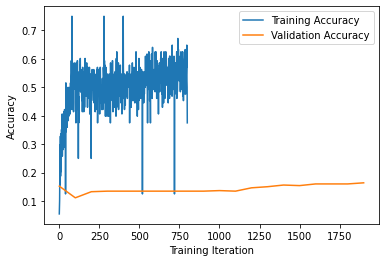

In [17]:
import matplotlib.pyplot as plt
plt.plot(range(len(training_accuracies)), training_accuracies, label = "Training Accuracy")
plt.plot(list(map(lambda x: x * 100, range(len(validation_accuracies)))), validation_accuracies, label = "Validation Accuracy")
plt.xlabel("Training Iteration")
plt.ylabel("Accuracy")
plt.legend()